# Projeto Churn de Clientes

## Introduction

The objective of this project is to analyze and build a Machine Learning model based on customer churn data. The dataset contains information about a fictional telecommunications company that provided landline phone and internet services to 7,043 customers in California in the third quarter. It indicates which customers left, stayed, or signed up for their service.
Churn prediction identifies customers who are likely to cancel their contracts soon. If the company can do this, it can address the users before churn. 

The target variable we want to predict is categorical and has only two possible outcomes: churn or non-churn (Binary Classification).
We would also like to understand why the model thinks our customers are leaving, and for that, we need to be able to interpret the model's predictions. According to the description, this dataset contains the following information:
* Customer services: phone; multiple lines; internet; tech support and extra services, such as online security, backup, device protection, and TV streaming
* Account information: how long they've been a customer, contract type, payment method type
* Charges: how much was charged to the customer last month and in total
* Demographic information: gender, age, and whether they have dependents or a partner
* Churn: yes/no, whether the customer left the company last month

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, make_scorer, recall_score, precision_recall_curve, auc
from imblearn.combine import SMOTETomek
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from IPython.display import display
import lightgbm as lgb
import shap
import joblib
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset-churn.csv')

## Exploratory Data Analysis (EDA)

In [3]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
775,8823-RLPWL,Female,0,Yes,No,72,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),110.65,8065.65,No
1839,9350-ZXYJC,Female,0,No,No,4,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),25.30,116.95,No
3054,6465-GSRCL,Female,0,No,Yes,67,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),106.60,7244.7,No
2631,6861-XWTWQ,Male,1,Yes,No,7,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.25,665.45,Yes
3490,7743-EXURX,Male,0,Yes,Yes,8,Yes,No,DSL,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,51.05,415.05,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The column TotalCharges is currently an object and needs to be converted to a numeric type.

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
# Checking Missing Values
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


The TotalCharges column has 11 missing values. Let's analyze it to define the best strategy to handle them.

In [9]:
# Displaying the Full Rows with Missing Value
df[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


We observe that the rows with missing TotalCharges have a tenure of 0. This means they are new customers who haven't accumulated any charges yet. Therefore, we will impute these missing values with 0.

In [10]:
# Filling the missing values with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [11]:
# Checking Missing Values Again
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

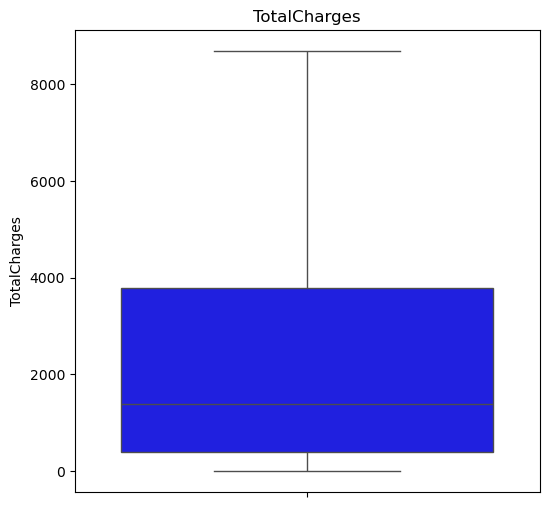

In [12]:
plt.figure(figsize = (6, 6))
plt.title("TotalCharges")
sns.boxplot(data = df['TotalCharges'], color = 'blue')
plt.show()

### Univariate Analysis

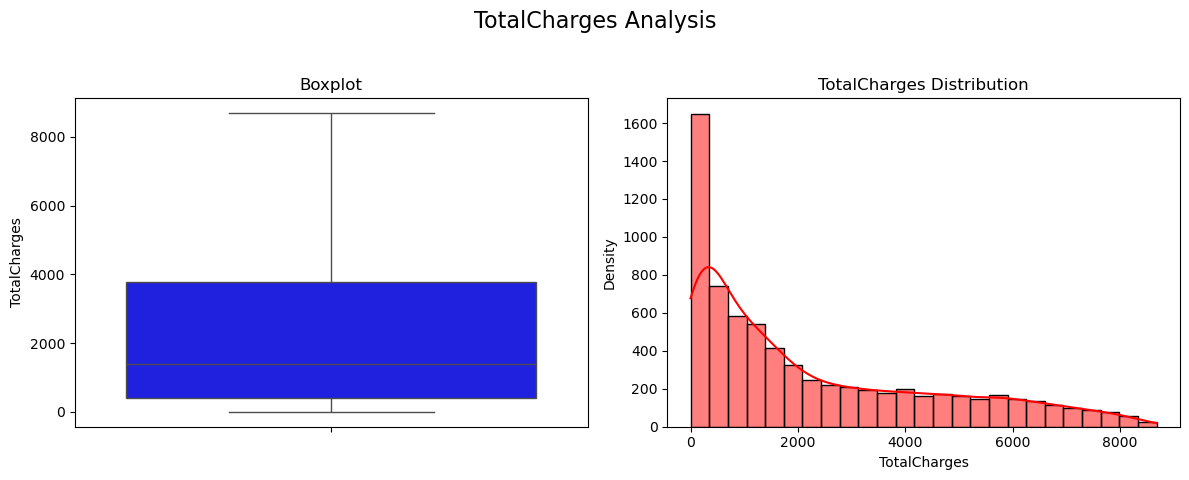

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('TotalCharges Analysis', fontsize=16)

sns.boxplot(data=df['TotalCharges'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')

sns.histplot(df['TotalCharges'], color='red', kde=True, ax=axes[1])
axes[1].set_title('TotalCharges Distribution')
axes[1].set_ylabel('Density')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

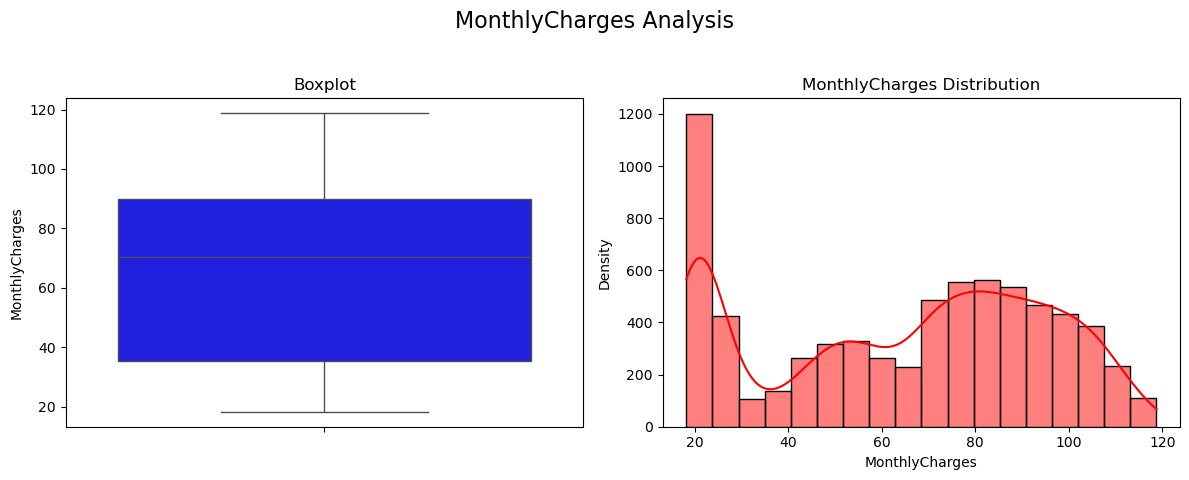

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('MonthlyCharges Analysis', fontsize=16)

sns.boxplot(data=df['MonthlyCharges'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')

sns.histplot(df['MonthlyCharges'], color='red', kde=True, ax=axes[1])
axes[1].set_title('MonthlyCharges Distribution')
axes[1].set_ylabel('Density')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

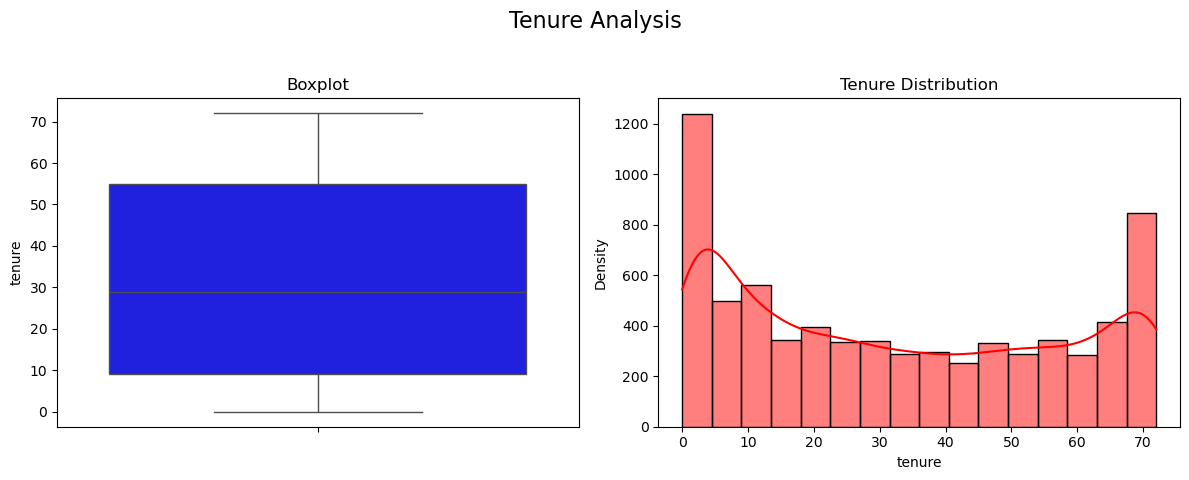

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Tenure Analysis', fontsize=16)

sns.boxplot(data=df['tenure'], color='blue', ax=axes[0])
axes[0].set_title('Boxplot')

sns.histplot(df['tenure'], color='red', kde=True, ax=axes[1])
axes[1].set_title('Tenure Distribution')
axes[1].set_ylabel('Density')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We are going to replace 'No internet service' and 'No phone service' with 'No'. This is because they carry the same meaning (the customer does not have that particular service), and keeping them as separate categories would create unnecessary features without adding relevant information for the model.

In [16]:
# List of values to be replaced
valores_substituir = ["No internet service", "No phone service"]
# Replace these values with "No" across the DataFrame
df = df.replace(valores_substituir, "No")

Let's analyze the churn rate across our categorical variables, comparing the rate for each category against the global average churn rate

Global Mean Churn Rate: 0.27


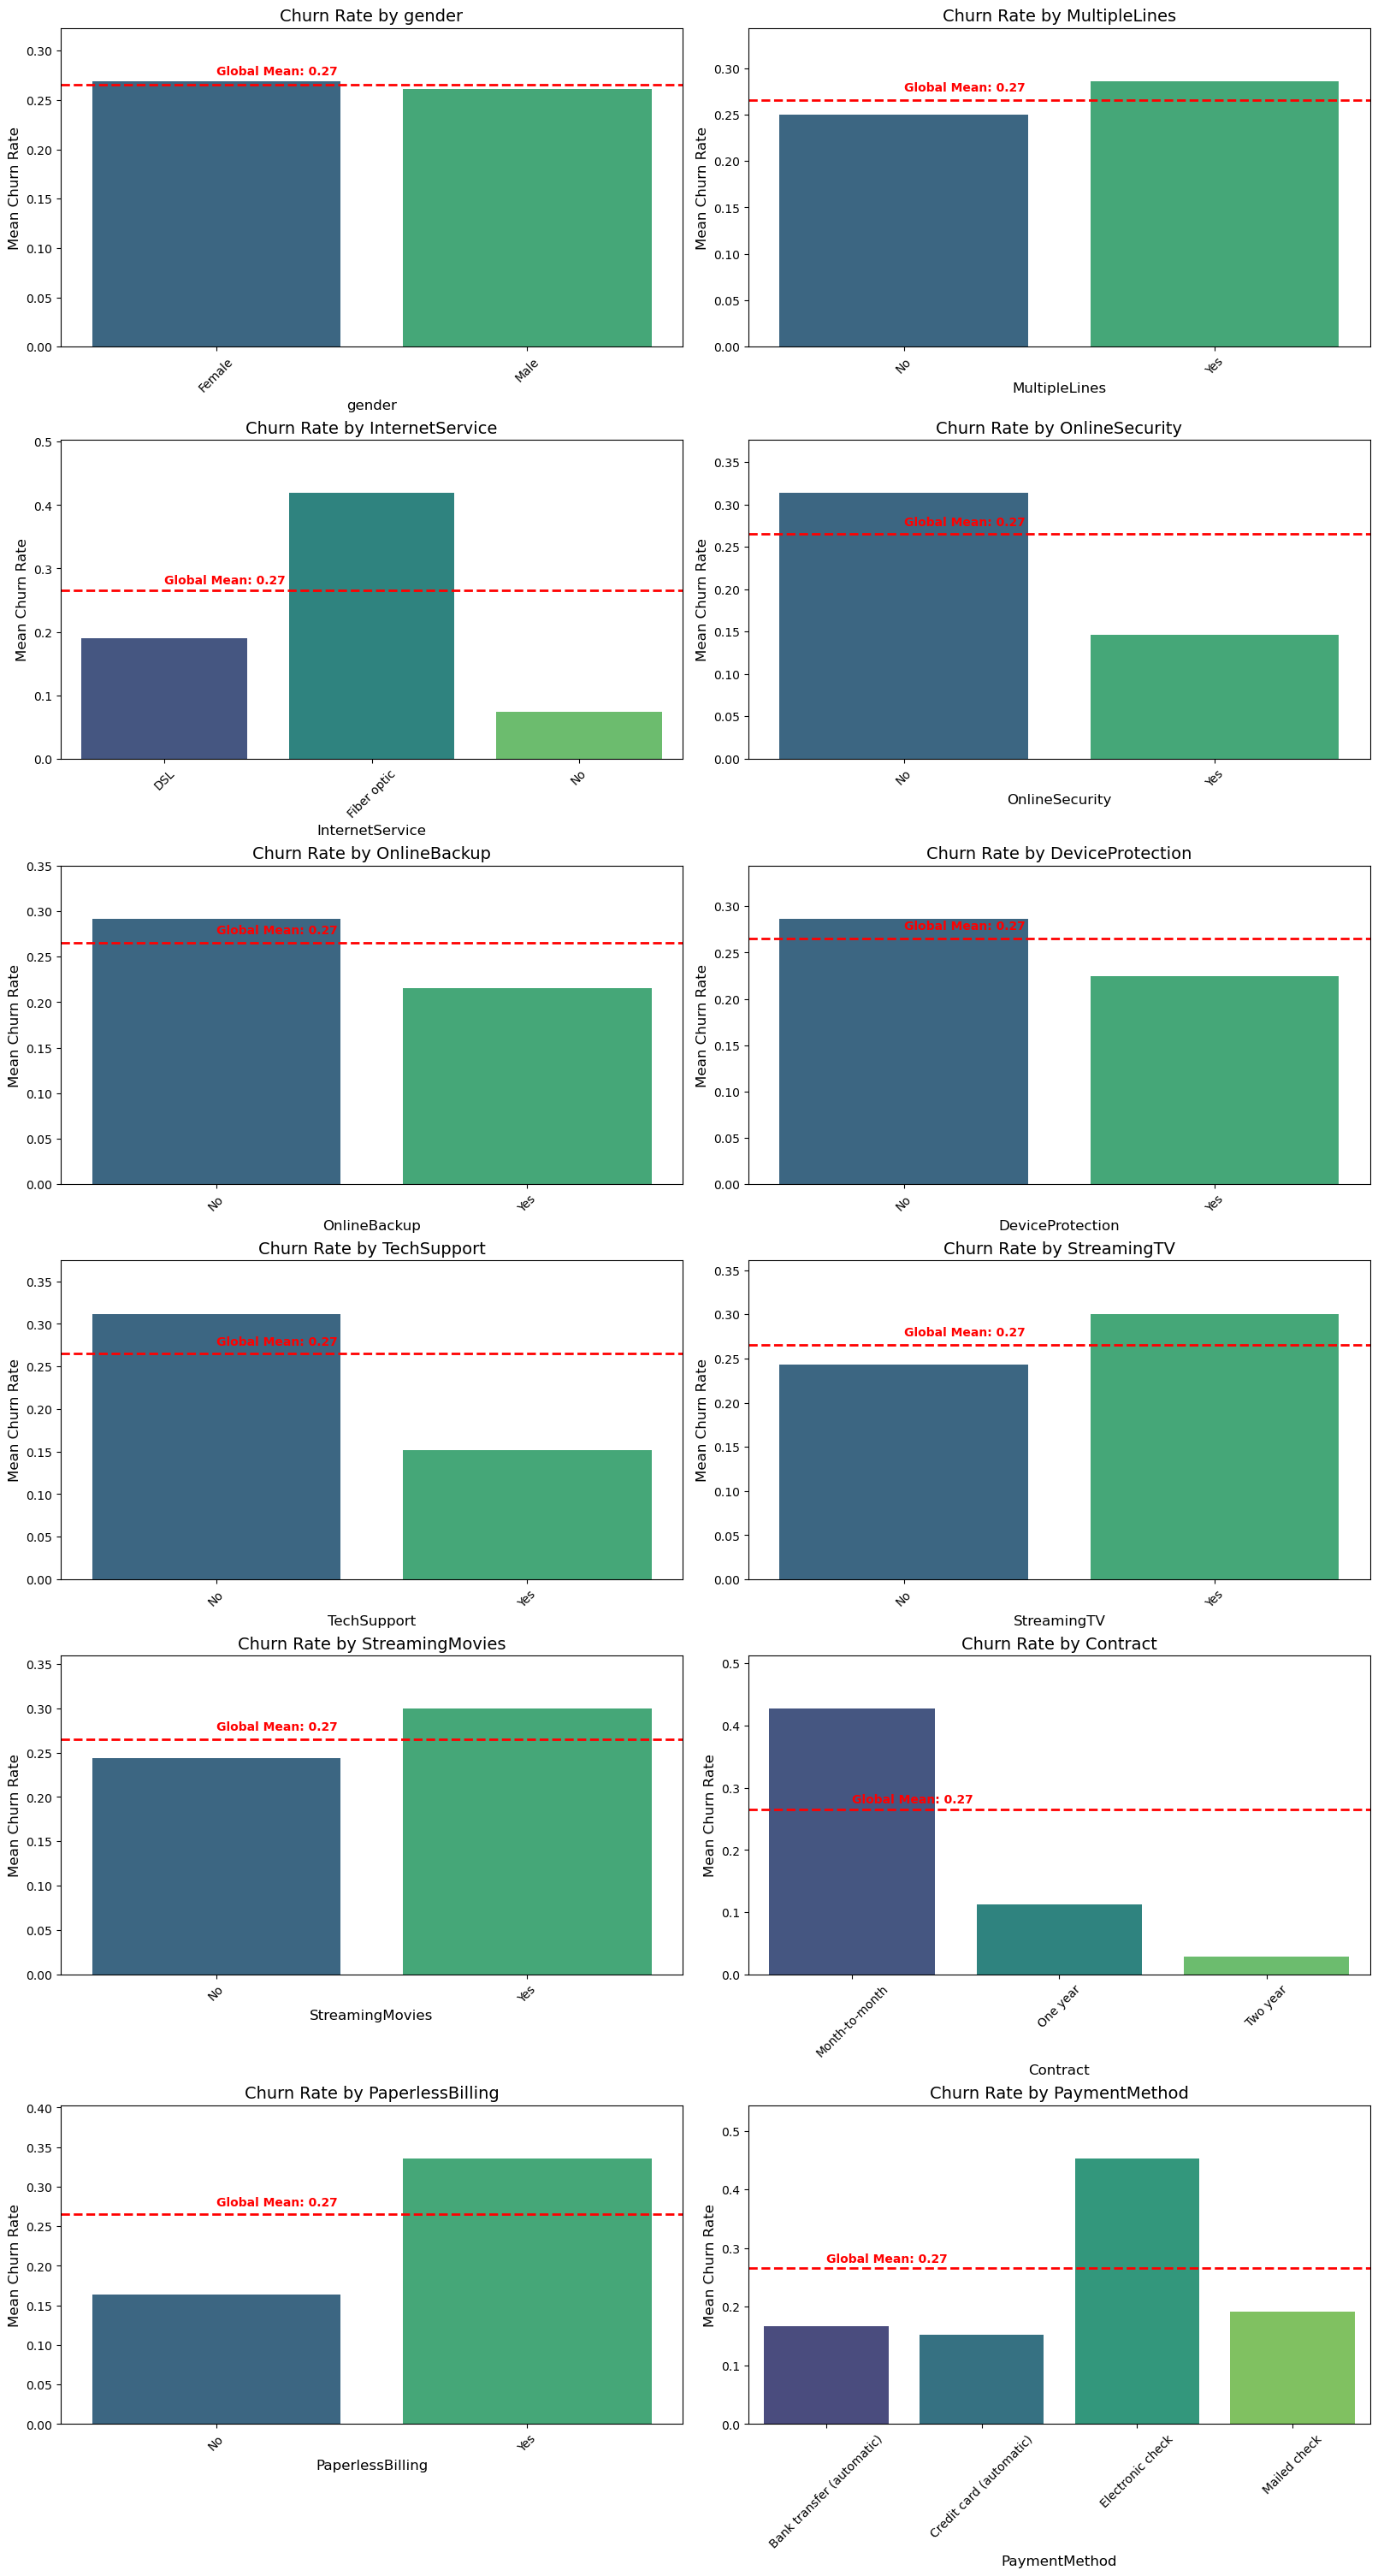

In [17]:
df_copy = df.copy()
df_copy['Churn'] = df_copy['Churn'].map({'No': 0, 'Yes': 1})
categorical_features = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
]
global_mean = df_copy['Churn'].mean()
print(f"Global Mean Churn Rate: {global_mean:.2f}")

n_features = len(categorical_features)
ncols = 2
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 5), constrained_layout=True)
axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

for i, feature in enumerate(categorical_features):
    df_group = df_copy.groupby(by=feature)['Churn'].agg(['mean']).reset_index()
    ax = axes[i]
    graph = sns.barplot(x=feature, y='mean', data=df_group, palette='viridis', ax=ax)
    ax.axhline(global_mean, linewidth=2, color='red', linestyle='--')
    ax.text(0, global_mean + 0.01, f"Global Mean: {global_mean:.2f}", color='red', weight='semibold')
    ax.set_title(f"Churn Rate by {feature}", fontsize=14)
    ax.set_ylabel("Mean Churn Rate", fontsize=12)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylim(0, max(df_group['mean'].max() * 1.2, global_mean * 1.2))
    ax.tick_params(axis='x', labelrotation=45)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.show()


### Bivariate Analysis

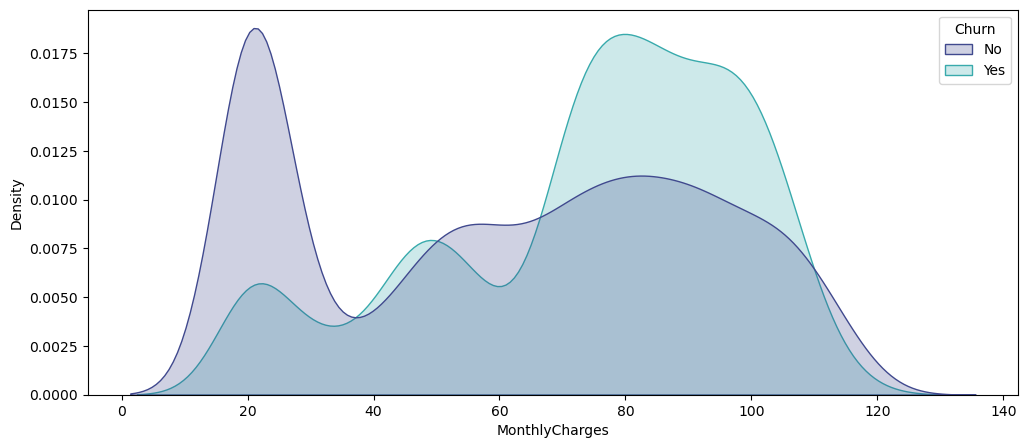

In [18]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

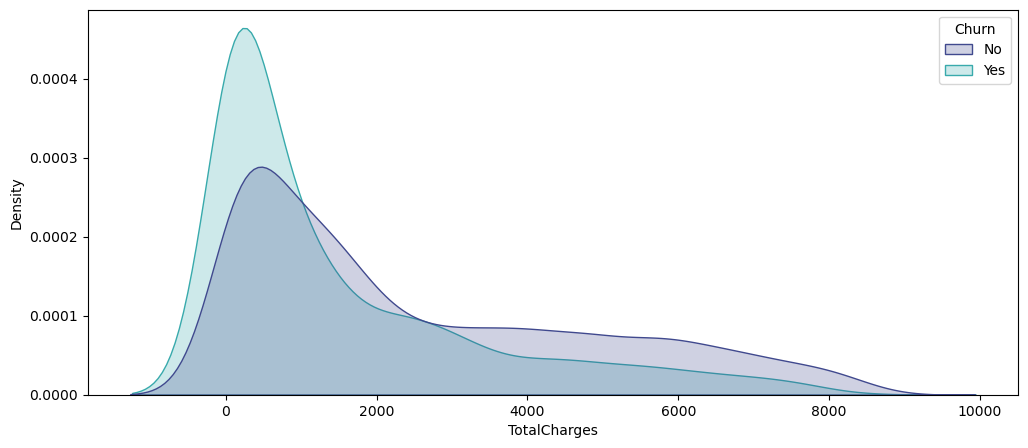

In [19]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

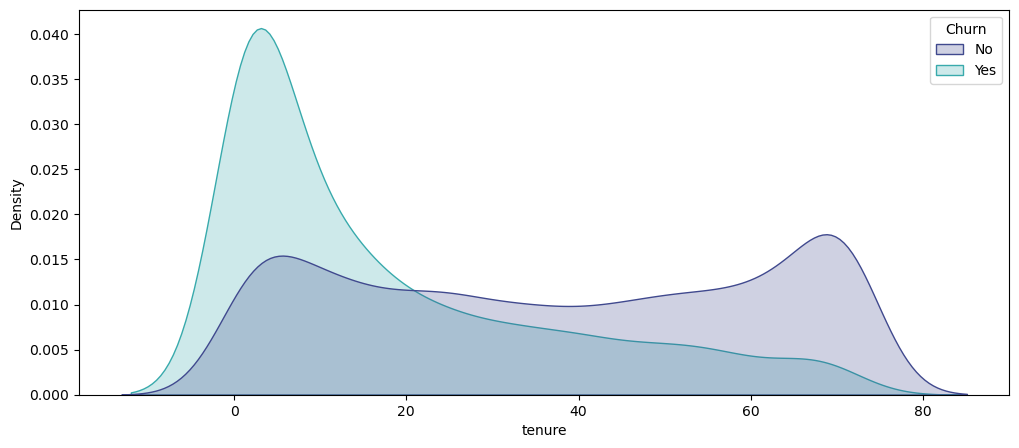

In [20]:
plt.figure(figsize = (12, 5))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.show()

## Insights

The average churn rate found in the dataset is approximately 27%, meaning that roughly one in every four customers terminates their contract. This is a significant rate and should be treated as a critical retention indicator. An analysis of the tenure variable shows a median of 29 months, but with 25% of customers staying for nine months or less, revealing a high concentration of short-term customers and suggesting that early churn is a primary risk.

Regarding billing, the MonthlyCharges variable has a mean of around 64.8 but with a wide spread, indicating highly distinct consumption profiles. TotalCharges, in turn, reflects both the variation in contract length and the accumulation of spending over time.

Observing the categorical variables, it's notable that customers on month-to-month contracts, those who use paperless billing, and those with certain payment methods exhibit churn rates higher than the global average. These profiles, therefore, constitute strategic targets for targeted interventions. It is also worth highlighting that the data handling applied to TotalCharges was essential to prevent distortions and ensure consistency in the comparisons made.

The relationship between churn and tenure reveals that customers who cancel tend to be concentrated in the first few months of their contract, reinforcing the need for specific onboarding and loyalty strategies in the very first cycles. The comparison between churn and MonthlyCharges indicates that there are billing ranges in which the propensity to cancel is higher, especially among customers with higher invoice values, which suggests a need to evaluate the perceived cost-benefit in this segment.

## Data Preprocessing

In [21]:
# Dropping the customerID column as it has no predictive value.
df = df.drop('customerID', axis=1) 

In [22]:
df.describe(include=['object', 'bool'])

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,4072,3096,5024,4614,4621,4999,4336,4311,3875,4171,2365,5174


In [23]:
# 1. Label Encoding for binary variables
binarias = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn'
]

In [24]:
# Mapping Yes/No to 1/0 and Male/Female to 1/0
mapeamento = {'Yes': 1,'No': 0,'Male': 1,'Female': 0}
for col in binarias:
    df[col] = df[col].map(mapeamento)

In [25]:
# 2. One-Hot Encoding for nominal variables
nominais = ['InternetService', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=nominais, drop_first=True, dtype=int)

<Axes: >

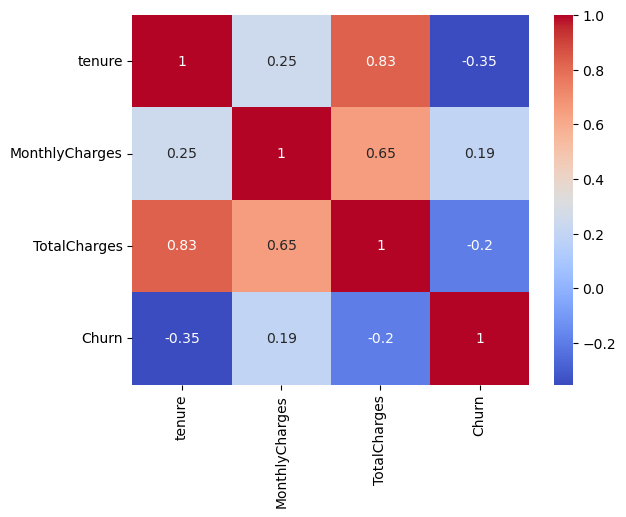

In [26]:
# Correlation Analysis of Numerical Variables
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr(), annot=True, cmap='coolwarm')

In [27]:
# Correlation Analysis with the 'Churn' Column
corr_matrix = df.corr()
corr_churn = corr_matrix['Churn'].sort_values(ascending=False)
print(corr_churn)

Churn                                    1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV                              0.063228
StreamingMovies                          0.061382
MultipleLines                            0.040102
PhoneService                             0.011942
gender                                  -0.008612
DeviceProtection                        -0.066160
OnlineBackup                            -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport                             -0.164674
OnlineSecurity                          -0.171226
Contract_One year                       -0.177820


In [28]:
# Correlation Matrix
corr_matrix = df.corr()
limite = 0.7
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']
corr_high = corr_pairs[abs(corr_pairs['Correlation']) > limite].sort_values(
    by='Correlation', ascending=False
)
print("Highly correlated variables (|correlation| > 0.7):")
print(corr_high)
corr_filtrada = corr_matrix.mask(abs(corr_matrix) <= limite)

Highly correlated variables (|correlation| > 0.7):
               Var1                         Var2  Correlation
96           tenure                 TotalCharges     0.826178
233  MonthlyCharges  InternetService_Fiber optic     0.787066
234  MonthlyCharges           InternetService_No    -0.763557


The 0.826 correlation between tenure and TotalCharges is extremely high, indicating strong multicollinearity. TotalCharges is fundamentally the product of tenure and MonthlyCharges (or, more precisely, the sum of MonthlyCharges over the tenure). Keeping all three variables together would add redundancy and could complicate interpretability, especially for linear models, without necessarily adding more predictive power.

We opted to remove TotalCharges, as we still retain crucial information from tenure (the customer's length of stay, a key indicator of loyalty and maturity) and MonthlyCharges (the current cost of service, which correlates with the quality/service package and is a strong predictor of churn). Together, these two variables already capture the essence of what TotalCharges represents.

The other strong correlations reflect the intrinsic business relationship between the service value (MonthlyCharges) and the service type (InternetService). Removing either of these variables would mean losing valuable information about the customer's service package, which is a very strong predictor of churn. The Machine Learning model can and should use this information to learn the relationship. The multicollinearity here is more of a reflection that one variable (MonthlyCharges) is heavily influenced by another (InternetService), and both are relevant.

In [29]:
# # Dropping the TotalCharges column
df = df.drop('TotalCharges', axis=1) 

Churn Count:
Churn
0    5174
1    1869
Name: count, dtype: int64


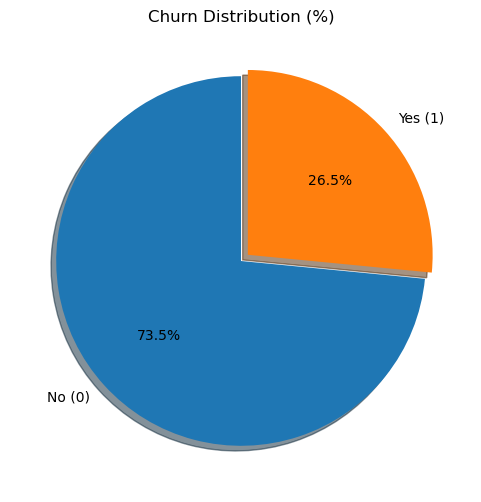

In [30]:
# Distribution of the Target Variable
churn_counts = df['Churn'].value_counts()
print("Churn Count:")
print(churn_counts)
plt.figure(figsize=(6,6))
plt.pie(
    churn_counts, 
    labels=['No (0)', 'Yes (1)'],   
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#1f77b4', '#ff7f0e'],
    explode=(0,0.05),
    shadow=True
)
plt.title("Churn Distribution (%)")
plt.show()


We are facing a class imbalance problem in our target variable. To address this, we will test different strategies and approaches to determine which one yields the best model. Our objective is to build a model with an accuracy above 80%.

Why Recall?
In the context of customer churn prediction, Recall (also known as Sensitivity or True Positive Rate) is the primary metric to optimize. It measures our model's ability to correctly identify the highest possible proportion of customers who will actually leave the company (the "Churn" minority class).

Minimizing Customer Losses (False Negatives): The cost of a False Negative (a customer the model predicted would not churn, but who actually did) is typically very high for a business. Each lost customer represents not only the interruption of future revenue but also the potential loss of Lifetime Value (LTV), the costs of acquiring new customers, and a negative impact on reputation. A high Recall means we are minimizing these False Negatives, ensuring that most customers at risk of churning are flagged for intervention.

Opportunity for Proactive Intervention: By identifying a customer with a high probability of churning (thanks to a high Recall), the company gains the opportunity to implement targeted retention strategies (personalized offers, proactive support, satisfaction surveys). Missing this opportunity due to a False Negative is the most costly error in this scenario.

Although Recall is the priority, we do not disregard Precision, F1-Score, and AUC-ROC:

In summary, our focus is to ensure that the largest possible number of at-risk customers are identified (high Recall), enabling effective retention actions. The other metrics help us refine the model, ensuring that these interventions are as efficient and targeted as possible, thus optimizing the return on investment (ROI) in churn prevention.

In [31]:
# Separating Features (X) and Target Variable (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [32]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# Scaling Numerical Variables
numeric_cols = ['tenure', 'MonthlyCharges']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

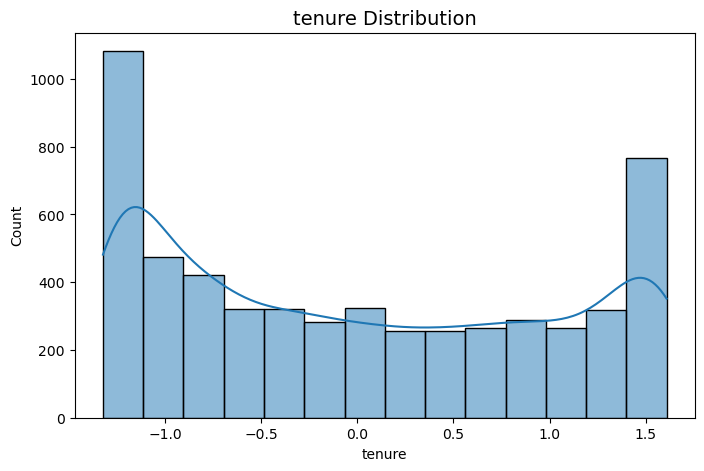

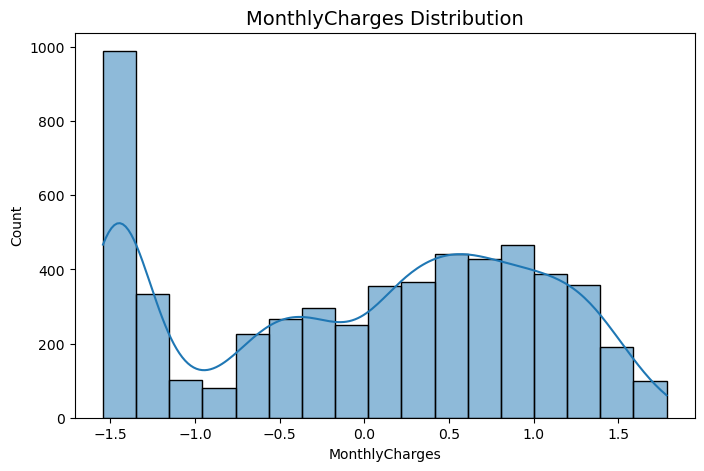

In [34]:
# Visualizing the variables after scaling
numeric_cols = ["tenure", 'MonthlyCharges']
for feat in numeric_cols:
    plt.figure(figsize=(8, 5)) 
    sns.histplot(data=X_train, x=feat, kde=True)
    plt.title(f'{feat} Distribution', fontsize=14)
    plt.show()

## Building and Evaluating Machine Learning Models

### Logistic Regression

In [35]:
log_reg_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
y_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1]


--- Classification Report (Logistic Regression) ---
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



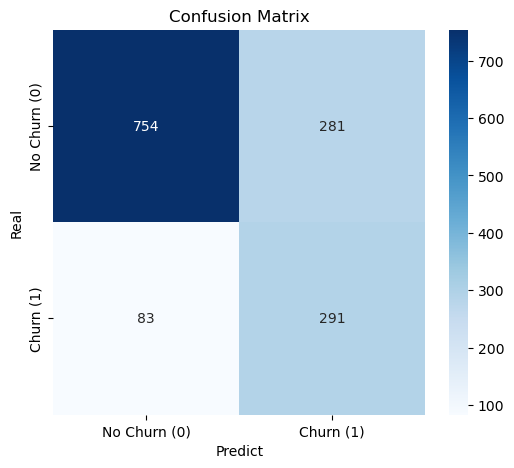


AUC-ROC (Logistic Regression): 0.8389


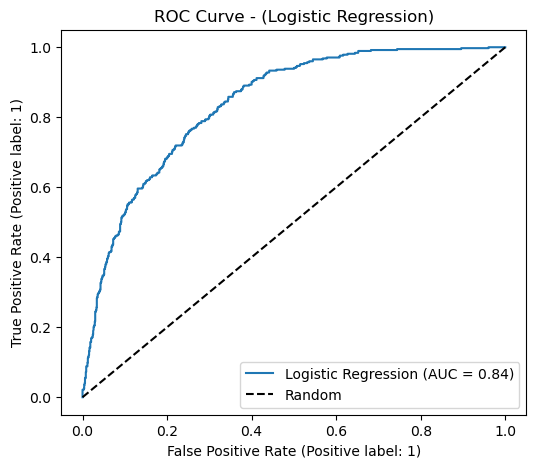

In [36]:
print("\n--- Classification Report (Logistic Regression) ---")
print(classification_report(y_test, y_pred_log_reg))

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predict')
plt.title('Confusion Matrix')
plt.show()
# AUC-ROC
auc_log_reg = roc_auc_score(y_test, y_proba_log_reg)
print(f"\nAUC-ROC (Logistic Regression): {auc_log_reg:.4f}")
# Plotar Curva ROC
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax, name='Logistic Regression')
plt.title('ROC Curve - (Logistic Regression)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### Random Forest

In [37]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]


--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



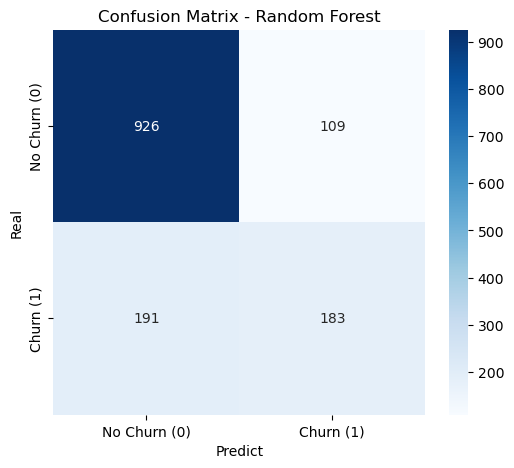


AUC-ROC (Random Forest): 0.8195


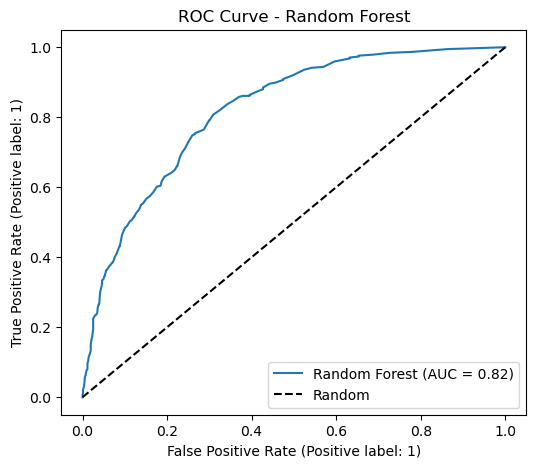

In [38]:
print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predict')
plt.title('Confusion Matrix - Random Forest')
plt.show()
# Calcular e exibir AUC-ROC
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\nAUC-ROC (Random Forest): {auc_rf:.4f}")

# Plotar Curva ROC
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax, name='Random Forest')
plt.title('ROC Curve - Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### Using Class Balancing

To address class imbalance, a hybrid resampling approach combining SMOTE with undersampling is highly effective. SMOTE (Synthetic Minority Over-sampling Technique) avoids overfitting by creating new, synthetic samples for the minority class based on its nearest neighbors, rather than just duplicating data. This is then coupled with an undersampling technique, such as Tomek Links (as in SMOTETomek), which cleans the feature space by removing majority class samples that are close to the newly created synthetic minority points. This dual strategy results in a more balanced and less noisy dataset, allowing the model to learn a clearer and more robust decision boundary between the classes.

### Applying SMOTE + Undersampling (SMOTETomek)

In [39]:
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("\nClass Distribution After Applying SMOTETomek")
print(y_train_resampled.value_counts())


Class Distribution After Applying SMOTETomek
Churn
0    3965
1    3965
Name: count, dtype: int64


### Logistic Regression SMOTETomek


--- Classification Report (Logistic Regression with SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



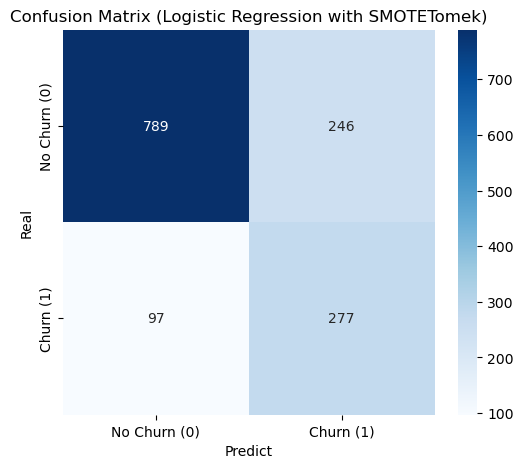


AUC-ROC (Logistic Regression with SMOTETomek): 0.8323


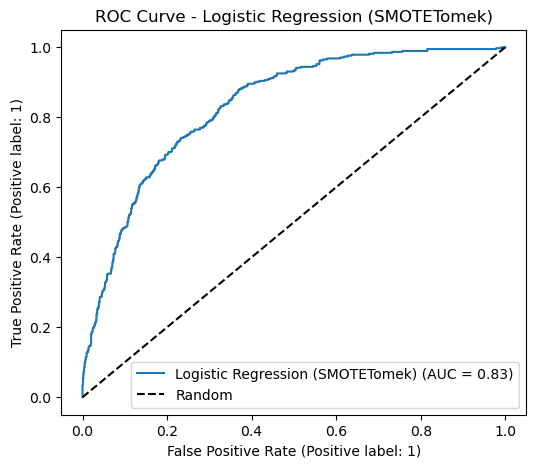

In [40]:
log_reg_smote_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000) # SEM class_weight='balanced'
log_reg_smote_model.fit(X_train_resampled, y_train_resampled)
y_pred_log_reg_smote = log_reg_smote_model.predict(X_test)
y_proba_log_reg_smote = log_reg_smote_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report (Logistic Regression with SMOTETomek) ---")
print(classification_report(y_test, y_pred_log_reg_smote))

cm_log_reg_smote = confusion_matrix(y_test, y_pred_log_reg_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predict')
plt.title('Confusion Matrix (Logistic Regression with SMOTETomek)')
plt.show()

auc_log_reg_smote = roc_auc_score(y_test, y_proba_log_reg_smote)
print(f"\nAUC-ROC (Logistic Regression with SMOTETomek): {auc_log_reg_smote:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(log_reg_smote_model, X_test, y_test, ax=ax, name='Logistic Regression (SMOTETomek)')
plt.title('ROC Curve - Logistic Regression (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### Random Forest with SMOTETomek


--- Classification Report (Random Forest with SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1035
           1       0.55      0.64      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.77      0.77      1409



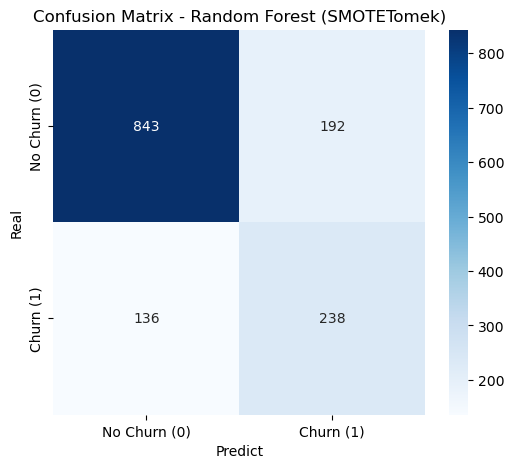


AUC-ROC (Random Forest w/ SMOTETomek): 0.8167


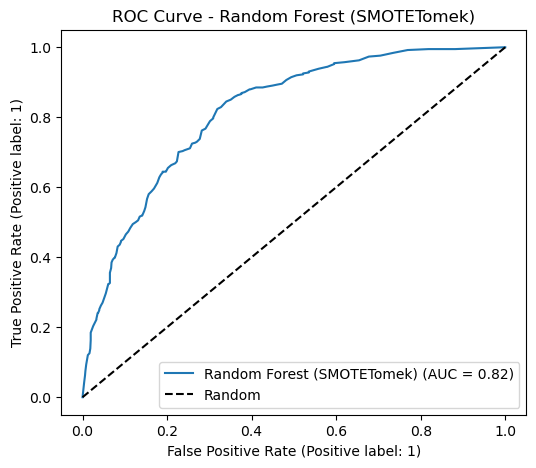

In [41]:
rf_smote_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_smote_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf_smote = rf_smote_model.predict(X_test)
y_proba_rf_smote = rf_smote_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report (Random Forest with SMOTETomek) ---")
print(classification_report(y_test, y_pred_rf_smote))

cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Real')
plt.xlabel('Predict')
plt.title('Confusion Matrix - Random Forest (SMOTETomek)')
plt.show()

auc_rf_smote = roc_auc_score(y_test, y_proba_rf_smote)
print(f"\nAUC-ROC (Random Forest w/ SMOTETomek): {auc_rf_smote:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf_smote_model, X_test, y_test, ax=ax, name='Random Forest (SMOTETomek)')
plt.title('ROC Curve - Random Forest (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### SVM with SMOTETomek


--- Classification Report (SVM with SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.73      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



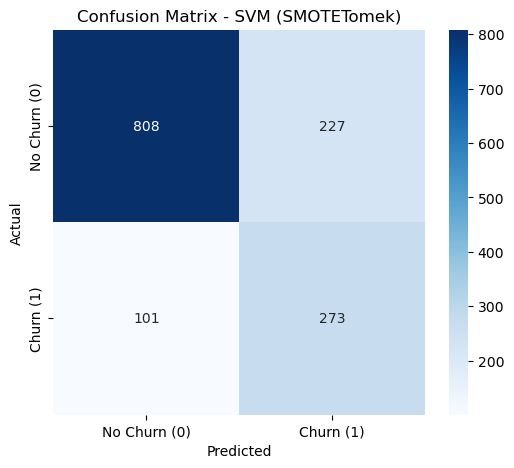


AUC-ROC (SVM with SMOTETomek): 0.8233


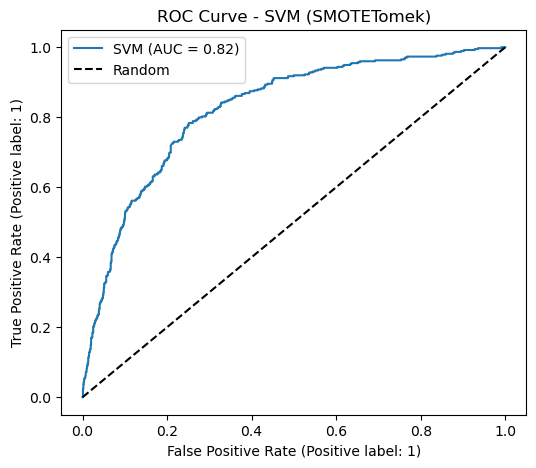

In [42]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report (SVM with SMOTETomek) ---")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVM (SMOTETomek)')
plt.show()

auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"\nAUC-ROC (SVM with SMOTETomek): {auc_svm:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(svm_model, X_test, y_test, ax=ax, name='SVM')
plt.title('ROC Curve - SVM (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### Decision Tree with SMOTETomek


--- Classification Report (Decision Tree with SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1035
           1       0.50      0.61      0.55       374

    accuracy                           0.73      1409
   macro avg       0.67      0.69      0.68      1409
weighted avg       0.75      0.73      0.74      1409



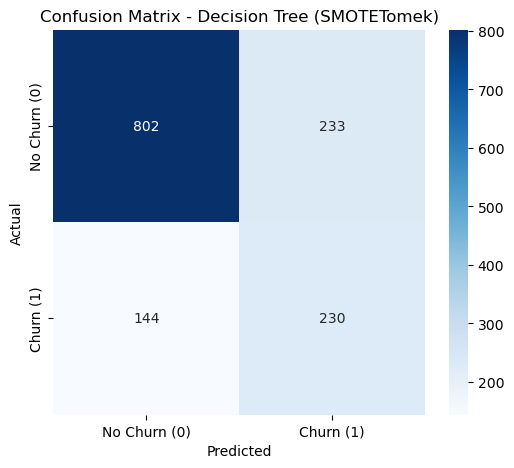


AUC-ROC (Decision Tree with SMOTETomek): 0.6958


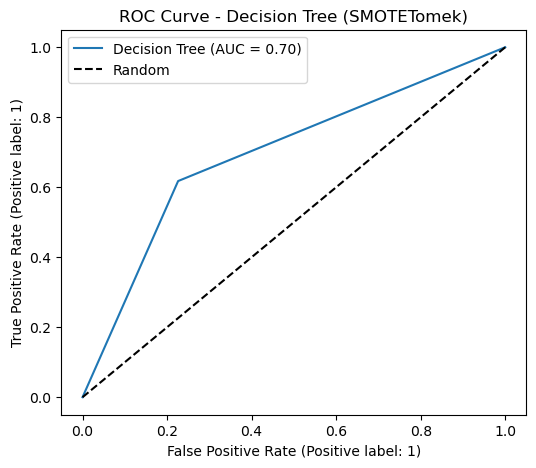

In [43]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report (Decision Tree with SMOTETomek) ---")
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Decision Tree (SMOTETomek)')
plt.show()

auc_dt = roc_auc_score(y_test, y_proba_dt)
print(f"\nAUC-ROC (Decision Tree with SMOTETomek): {auc_dt:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(dt_model, X_test, y_test, ax=ax, name='Decision Tree')
plt.title('ROC Curve - Decision Tree (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### XGBoost with SMOTETomek


--- Classification Report (XGBoost with SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409



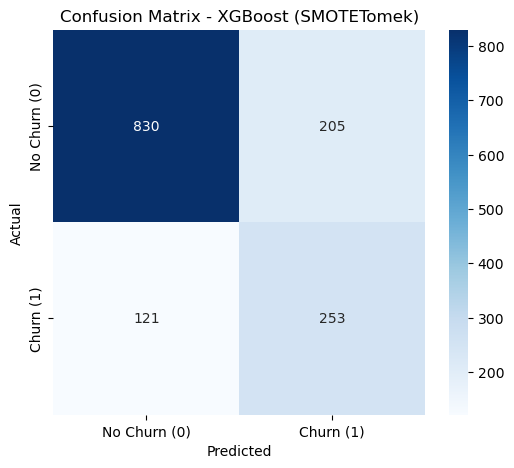


AUC-ROC (XGBoost with SMOTETomek): 0.8169


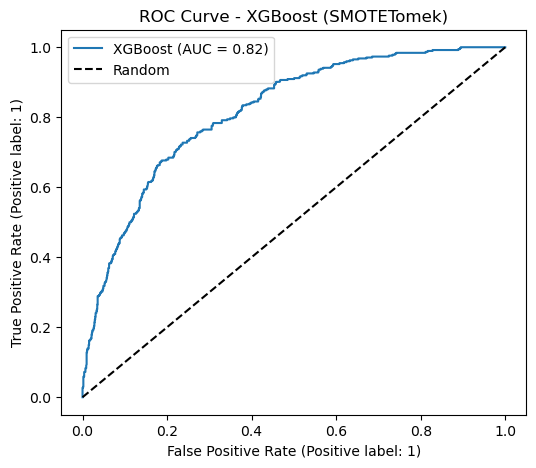

In [44]:
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report (XGBoost with SMOTETomek) ---")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost (SMOTETomek)')
plt.show()

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"\nAUC-ROC (XGBoost with SMOTETomek): {auc_xgb:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax, name='XGBoost')
plt.title('ROC Curve - XGBoost (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### LightGBM with SMOTETomek

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3965, number of negative: 3965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 7930, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- Classification Report (LightGBM with SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.69      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409



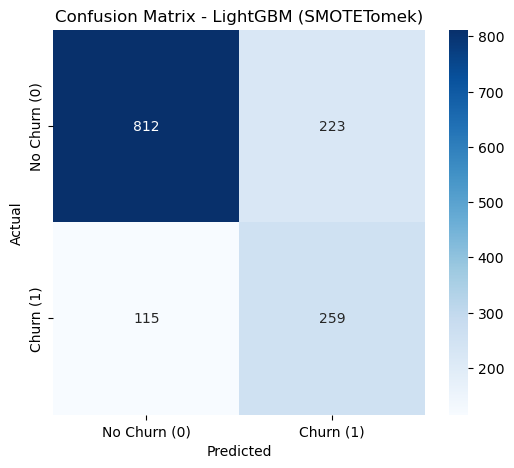


AUC-ROC (LightGBM with SMOTETomek): 0.8268


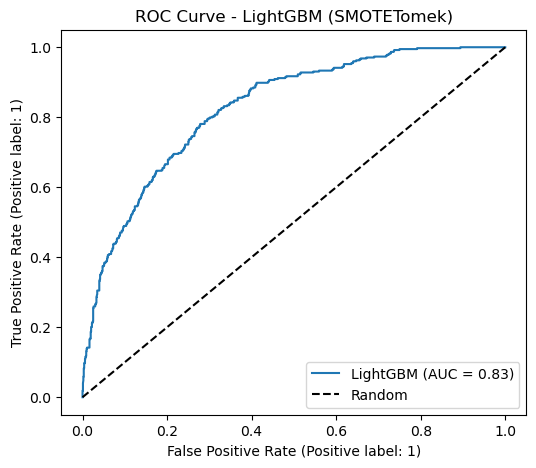

In [45]:
lgbm_model = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
lgbm_model.fit(X_train_resampled, y_train_resampled)
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]


print("\n--- Classification Report (LightGBM with SMOTETomek) ---")
print(classification_report(y_test, y_pred_lgbm))

cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LightGBM (SMOTETomek)')
plt.show()

auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
print(f"\nAUC-ROC (LightGBM with SMOTETomek): {auc_lgbm:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(lgbm_model, X_test, y_test, ax=ax, name='LightGBM')
plt.title('ROC Curve - LightGBM (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### K-Nearest Neighbors (KNN) with SMOTETomek


--- Classification Report (KNN with SMOTETomek) ---
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1035
           1       0.48      0.74      0.58       374

    accuracy                           0.72      1409
   macro avg       0.68      0.72      0.68      1409
weighted avg       0.77      0.72      0.73      1409



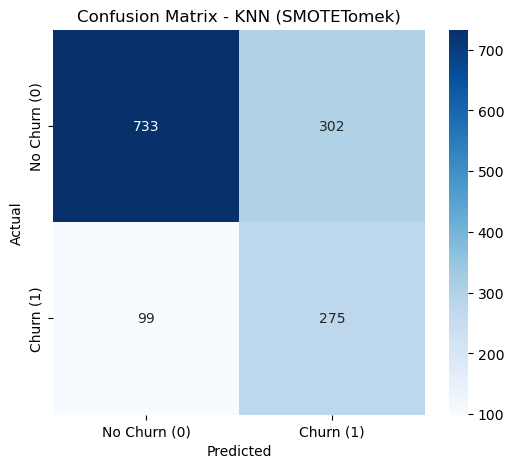


AUC-ROC (KNN with SMOTETomek): 0.7799


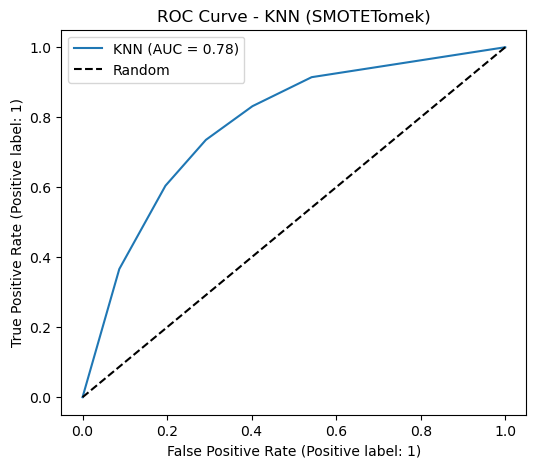

In [46]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report (KNN with SMOTETomek) ---")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - KNN (SMOTETomek)')
plt.show()

auc_knn = roc_auc_score(y_test, y_proba_knn)
print(f"\nAUC-ROC (KNN with SMOTETomek): {auc_knn:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(knn_model, X_test, y_test, ax=ax, name='KNN')
plt.title('ROC Curve - KNN (SMOTETomek)')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### Results Summary

| Model                     | Approach                   | Precision (Churn=1)| Recall (Churn=1) | F1-Score (Churn=1) | AUC-ROC |
| :------------------------- | :------------------------ | :----------------- | :--------------- | :----------------- | :------ |
| Logistic Regression        | `class_weight='balanced'` | 0.51               | **0.78**         | 0.62               | **0.8389**|
| Random Forest              | `class_weight='balanced'` | **0.63**           | 0.49             | 0.55               | 0.8195  |
| Logistic Regression        | SMOTETomek                | 0.53               | 0.74             | 0.62               | 0.8323  |
| Random Forest              | SMOTETomek                | 0.55               | 0.64             | 0.59               | 0.8167  |
| SVM                        | SMOTETomek                | 0.55               | 0.73             | 0.62               | 0.8233  |
| Decision Tree              | SMOTETomek                | 0.50               | 0.61             | 0.55               | 0.6958  |
| XGBoost                    | SMOTETomek                | 0.55               | 0.68             | 0.61               | 0.8169  |
| LightGBM                   | SMOTETomek                | 0.54               | 0.69             | 0.61               | 0.8268  |
| K-Nearest Neighbors (KNN)  | SMOTETomek                | 0.48               | **0.74**         | 0.58               | 0.7799  |

Top Performing Models (based on Recall and AUC for Churn):
1. Logistic Regression (class_weight='balanced'): Excellent Recall (0.78) and the best AUC (0.8389). Its main drawback is the lower Precision (0.51).
2. SVM (SMOTETomek): Good Recall (0.73) and F1-Score (0.62), with a solid AUC (0.8233).
3. LightGBM (SMOTETomek): Good Recall (0.69) and one of the best AUC scores (0.8268), with a competitive F1-Score (0.61).
4. XGBoost (SMOTETomek): Performance is very close to LightGBM, with slightly lower Recall and AUC, but it remains a strong contender.

### Cross-Validation and Hyperparameter Optimization

In [47]:
count_class_0 = y_train.value_counts()[0]
count_class_1 = y_train.value_counts()[1]
scale_pos_weight_value = count_class_0 / count_class_1
print(f"Number of No Churn (class 0) in training set: {count_class_0}")
print(f"Number of Churn (class 1) in training set: {count_class_1}")
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.4f}")
recall_scorer = make_scorer(recall_score, pos_label=1)

Number of No Churn (class 0) in training set: 4139
Number of Churn (class 1) in training set: 1495
Calculated scale_pos_weight: 2.7686


### Logistic Regression - Tunned


--- Optimizing Hyperparameters for Logistic Regression (class_weight='balanced') ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters (Logistic Regression): {'C': 0.001}
Best Recall (Logistic Regression) on CV: 0.7946

--- Classification Report (Tuned Logistic Regression) ---
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409



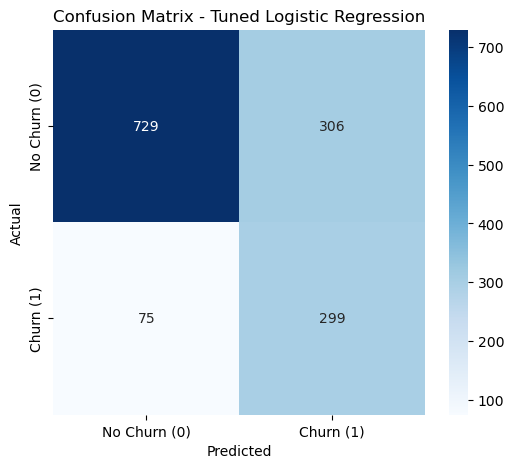

AUC-ROC (Tuned Logistic Regression): 0.8353


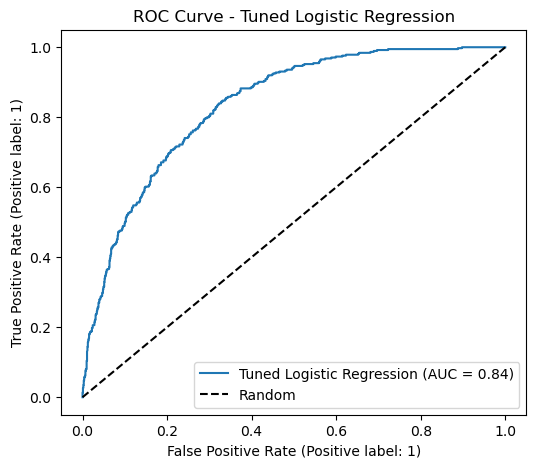

In [48]:
print("\n--- Optimizing Hyperparameters for Logistic Regression (class_weight='balanced') ---")
log_reg_base = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)

param_grid_lr = {
    'C': np.logspace(-3, 2, 6)
}

grid_search_lr = GridSearchCV(estimator=log_reg_base,
                               param_grid=param_grid_lr,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_lr.fit(X_train, y_train)
print(f"Best Parameters (Logistic Regression): {grid_search_lr.best_params_}")
print(f"Best Recall (Logistic Regression) on CV: {grid_search_lr.best_score_:.4f}")
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr_tuned = best_lr_model.predict(X_test)
y_proba_lr_tuned = best_lr_model.predict_proba(X_test)[:, 1]
print("\n--- Classification Report (Tuned Logistic Regression) ---")
print(classification_report(y_test, y_pred_lr_tuned))
cm_lr_tuned = confusion_matrix(y_test, y_pred_lr_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.show()

auc_lr_tuned = roc_auc_score(y_test, y_proba_lr_tuned)
print(f"AUC-ROC (Tuned Logistic Regression): {auc_lr_tuned:.4f}")
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_lr_model, X_test, y_test, ax=ax, name='Tuned Logistic Regression')
plt.title('ROC Curve - Tuned Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### Random Forest - Tunned



--- Optimizing Hyperparameters for Random Forest (class_weight='balanced') ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters (Random Forest): {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Recall (Random Forest) on CV: 0.7378

--- Classification Report (Random Forest Tuned) ---
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



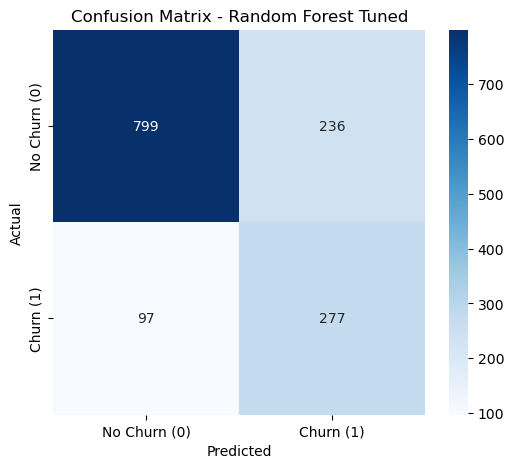

AUC-ROC (Random Forest Tuned): 0.8421


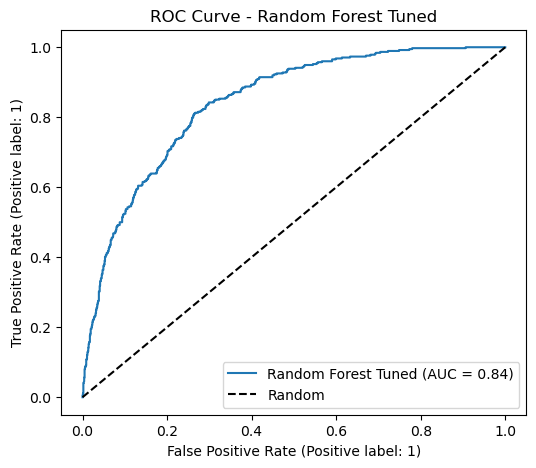

In [49]:
print("\n\n--- Optimizing Hyperparameters for Random Forest (class_weight='balanced') ---")

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(estimator=rf_base,
                               param_grid=param_grid_rf,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_rf.fit(X_train, y_train)

print(f"Best Parameters (Random Forest): {grid_search_rf.best_params_}")
print(f"Best Recall (Random Forest) on CV: {grid_search_rf.best_score_:.4f}")

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)
y_proba_rf_tuned = best_rf_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report (Random Forest Tuned) ---")
print(classification_report(y_test, y_pred_rf_tuned))

cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest Tuned')
plt.show()

auc_rf_tuned = roc_auc_score(y_test, y_proba_rf_tuned)
print(f"AUC-ROC (Random Forest Tuned): {auc_rf_tuned:.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_rf_model, X_test, y_test, ax=ax, name='Random Forest Tuned')
plt.title('ROC Curve - Random Forest Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### Support Vector Machine (SVM) - Tunned



--- Optimizing Hyperparameters for SVM (class_weight='balanced') ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (SVM): {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Best Recall (SVM) on CV: 0.8776

--- Classification Report (SVM Tuned) ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1035
           1       0.46      0.88      0.60       374

    accuracy                           0.69      1409
   macro avg       0.69      0.75      0.67      1409
weighted avg       0.81      0.69      0.71      1409



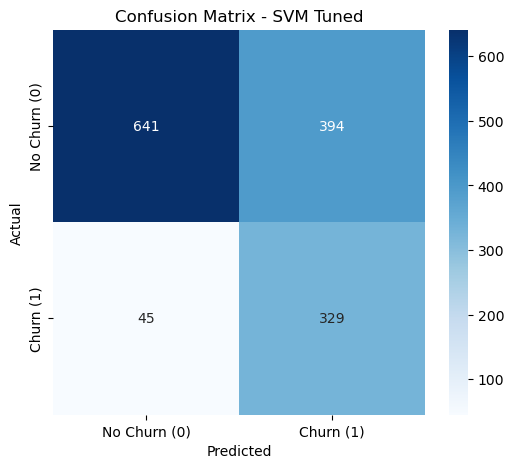

AUC-ROC (SVM Tuned): 0.8334


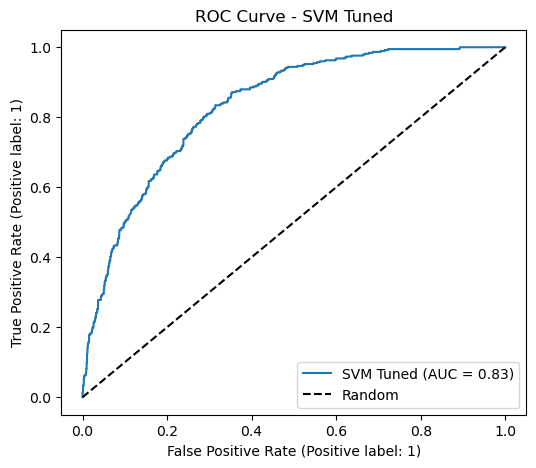

In [50]:
print("\n\n--- Optimizing Hyperparameters for SVM (class_weight='balanced') ---")
svm_base = SVC(class_weight='balanced', probability=True, random_state=42)

param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid_search_svm = GridSearchCV(estimator=svm_base,
                               param_grid=param_grid_svm,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_svm.fit(X_train, y_train)
print(f"Best Parameters (SVM): {grid_search_svm.best_params_}")
print(f"Best Recall (SVM) on CV: {grid_search_svm.best_score_:.4f}")

best_svm_model = grid_search_svm.best_estimator_
y_pred_svm_tuned = best_svm_model.predict(X_test)
y_proba_svm_tuned = best_svm_model.predict_proba(X_test)[:, 1]
print("\n--- Classification Report (SVM Tuned) ---")
print(classification_report(y_test, y_pred_svm_tuned))
cm_svm_tuned = confusion_matrix(y_test, y_pred_svm_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVM Tuned')
plt.show()
auc_svm_tuned = roc_auc_score(y_test, y_proba_svm_tuned)
print(f"AUC-ROC (SVM Tuned): {auc_svm_tuned:.4f}")
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_svm_model, X_test, y_test, ax=ax, name='SVM Tuned')
plt.title('ROC Curve - SVM Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### XGBoost- Tunned



--- Optimizing Hyperparameters for XGBoost (scale_pos_weight) ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Recall (XGBoost) on CV: 0.8294

--- Classification Report (XGBoost Tuned) ---
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.49      0.81      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409



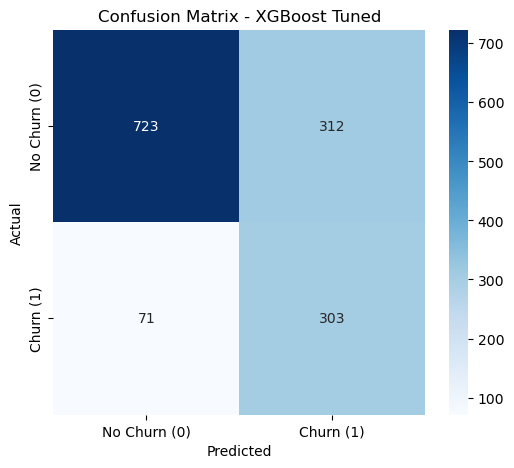

AUC-ROC (XGBoost Tuned): 0.8410


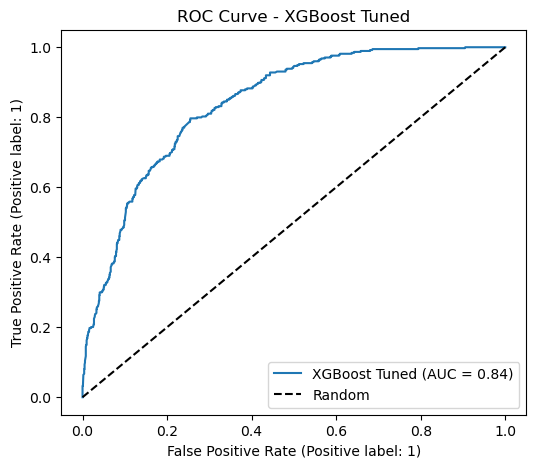

In [51]:
print("\n\n--- Optimizing Hyperparameters for XGBoost (scale_pos_weight) ---")

xgb_base = XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                         use_label_encoder=False, random_state=42,
                         scale_pos_weight=scale_pos_weight_value)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_base,
                               param_grid=param_grid_xgb,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_xgb.fit(X_train, y_train)
print(f"Best Parameters (XGBoost): {grid_search_xgb.best_params_}")
print(f"Best Recall (XGBoost) on CV: {grid_search_xgb.best_score_:.4f}")
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb_tuned = best_xgb_model.predict(X_test)
y_proba_xgb_tuned = best_xgb_model.predict_proba(X_test)[:, 1]
print("\n--- Classification Report (XGBoost Tuned) ---")
print(classification_report(y_test, y_pred_xgb_tuned))
cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost Tuned')
plt.show()
auc_xgb_tuned = roc_auc_score(y_test, y_proba_xgb_tuned)
print(f"AUC-ROC (XGBoost Tuned): {auc_xgb_tuned:.4f}")
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test, ax=ax, name='XGBoost Tuned')
plt.title('ROC Curve - XGBoost Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

### LightGBM - Tunned



--- Optimizing Hyperparameters for LightGBM (scale_pos_weight) ---
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
Best Parameters (LightGBM): {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Best Recall (LightGBM) on CV: 0.7873

--- Classification Report (LightGBM Tuned) ---
              precis

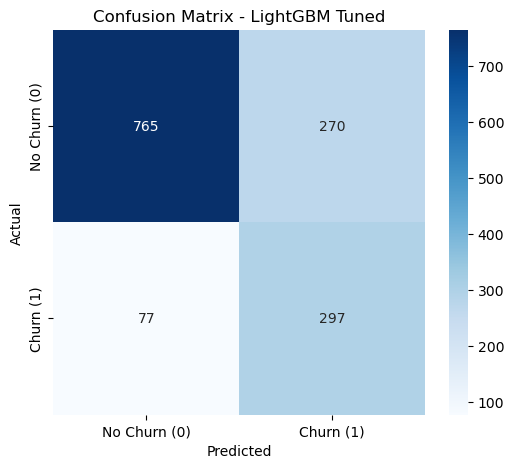

AUC-ROC (LightGBM Tuned): 0.8428


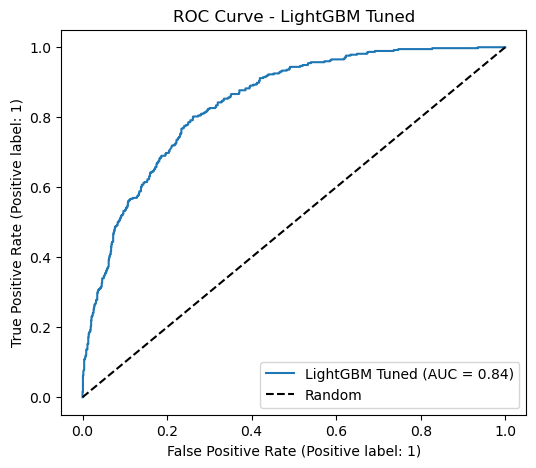

In [52]:
print("\n\n--- Optimizing Hyperparameters for LightGBM (scale_pos_weight) ---")

lgbm_base = LGBMClassifier(objective='binary', metric='binary_logloss',
                           random_state=42,
                           scale_pos_weight=scale_pos_weight_value)
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}
grid_search_lgbm = GridSearchCV(estimator=lgbm_base,
                               param_grid=param_grid_lgbm,
                               scoring=recall_scorer,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1,
                               verbose=1)

grid_search_lgbm.fit(X_train, y_train)
print(f"Best Parameters (LightGBM): {grid_search_lgbm.best_params_}")
print(f"Best Recall (LightGBM) on CV: {grid_search_lgbm.best_score_:.4f}")
best_lgbm_model = grid_search_lgbm.best_estimator_
y_pred_lgbm_tuned = best_lgbm_model.predict(X_test)
y_proba_lgbm_tuned = best_lgbm_model.predict_proba(X_test)[:, 1]
print("\n--- Classification Report (LightGBM Tuned) ---")
print(classification_report(y_test, y_pred_lgbm_tuned))
cm_lgbm_tuned = confusion_matrix(y_test, y_pred_lgbm_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LightGBM Tuned')
plt.show()
auc_lgbm_tuned = roc_auc_score(y_test, y_proba_lgbm_tuned)
print(f"AUC-ROC (LightGBM Tuned): {auc_lgbm_tuned:.4f}")
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_lgbm_model, X_test, y_test, ax=ax, name='LightGBM Tuned')
plt.title('ROC Curve - LightGBM Tuned')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.legend()
plt.show()

The optimized versions with scale_pos_weight consistently outperform their SMOTETomek-based counterparts in AUC, Recall, and F1-Score.
The conclusion is that, for this problem and dataset, using class_weight and scale_pos_weight in conjunction with hyperparameter optimization was the most effective strategy for achieving high Recall and AUC, surpassing the resampling approach with SMOTETomek.

### Analysis and Comparison of Model Performance Metrics

In [53]:
# Results Consolidation
# Original Models (Without Optimization)
data_initial = [
    ['Logistic Regression', "class_weight='balanced'", 0.51, 0.78, 0.62, 0.8389, "Inicial"],
    ['Random Forest', "class_weight='balanced'", 0.63, 0.49, 0.55, 0.8195, "Inicial"],
    ['Logistic Regression', "SMOTETomek", 0.53, 0.74, 0.62, 0.8323, "Inicial"],
    ['Random Forest', "SMOTETomek", 0.55, 0.64, 0.59, 0.8167, "Inicial"],
    ['SVM', "SMOTETomek", 0.55, 0.73, 0.62, 0.8233, "Inicial"],
    ['Decision Tree', "SMOTETomek", 0.50, 0.61, 0.55, 0.6958, "Inicial"],
    ['XGBoost', "SMOTETomek", 0.55, 0.68, 0.61, 0.8169, "Inicial"],
    ['LightGBM', "SMOTETomek", 0.54, 0.69, 0.61, 0.8268, "Inicial"],
    ['KNN', "SMOTETomek", 0.48, 0.74, 0.58, 0.7799, "Inicial"]
]

# Tuned Models (Optimized)
data_tuned = [
    ['Logistic Regression', "class_weight='balanced'", 0.49, 0.80, 0.61, 0.8353, "Tuned"],
    ['Random Forest', "class_weight='balanced'", 0.54, 0.74, 0.62, 0.8421, "Tuned"],
    ['SVM', "class_weight='balanced'", 0.46, 0.88, 0.60, 0.8334, "Tuned"],
    ['XGBoost', "scale_pos_weight", 0.49, 0.81, 0.61, 0.8410, "Tuned"],
    ['LightGBM', "scale_pos_weight", 0.52, 0.79, 0.63, 0.8428, "Tuned"]
]

# Consolidate
columns = ['Model', 'Aproach', 'Precision (Churn=1)', 'Recall (Churn=1)', 
           'F1-Score (Churn=1)', 'AUC-ROC', 'Status']
df_results = pd.DataFrame(data_initial + data_tuned, columns=columns)

In [54]:
# Sorting by Recall (Churn=1)
df_sorted = df_results.sort_values(by="Recall (Churn=1)", ascending=False).reset_index(drop=True)
display(df_sorted)

,Model,Aproach,Precision (Churn=1),Recall (Churn=1),F1-Score (Churn=1),AUC-ROC,Status
0,SVM,class_weight='balanced',0.46,0.88,0.60,0.8334,Tuned
1,XGBoost,scale_pos_weight,0.49,0.81,0.61,0.8410,Tuned
2,Logistic Regression,class_weight='balanced',0.49,0.80,0.61,0.8353,Tuned
3,LightGBM,scale_pos_weight,0.52,0.79,0.63,0.8428,Tuned
4,Logistic Regression,class_weight='balanced',0.51,0.78,0.62,0.8389,Inicial
5,Logistic Regression,SMOTETomek,0.53,0.74,0.62,0.8323,Inicial
6,KNN,SMOTETomek,0.48,0.74,0.58,0.7799,Inicial
7,Random Forest,class_weight='balanced',0.54,0.74,0.62,0.8421,Tuned
8,SVM,SMOTETomek,0.55,0.73,0.62,0.8233,Inicial
9,LightGBM,SMOTETomek,0.54,0.69,0.61,0.8268,Inicial


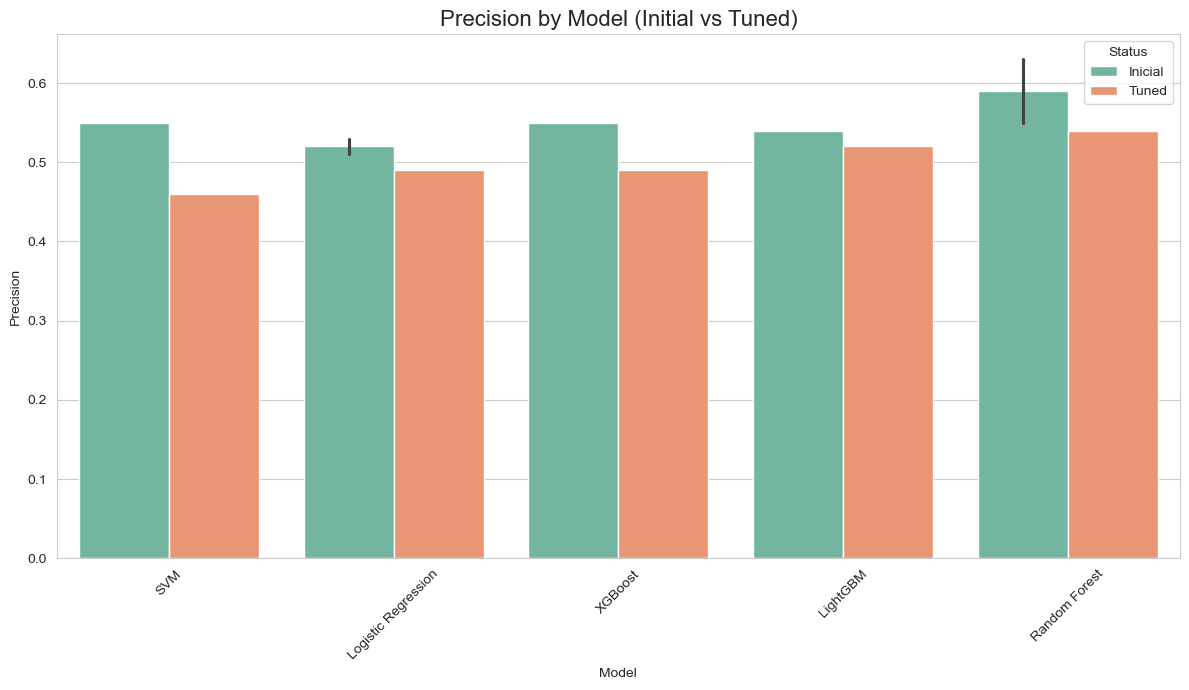

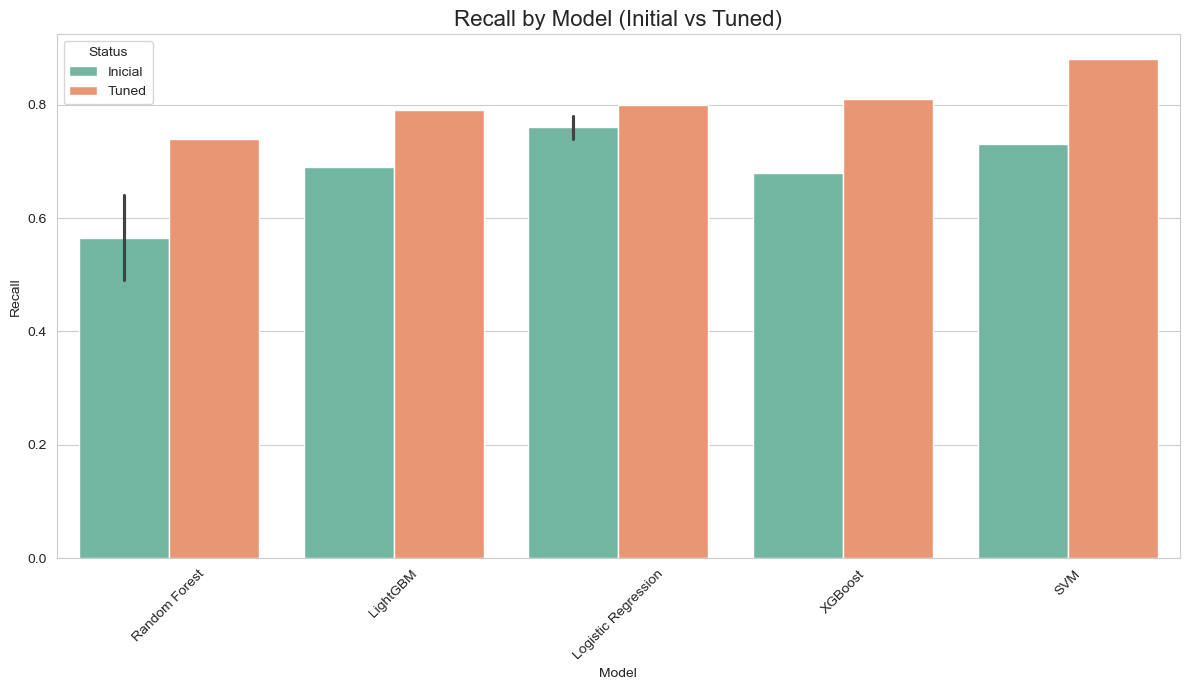

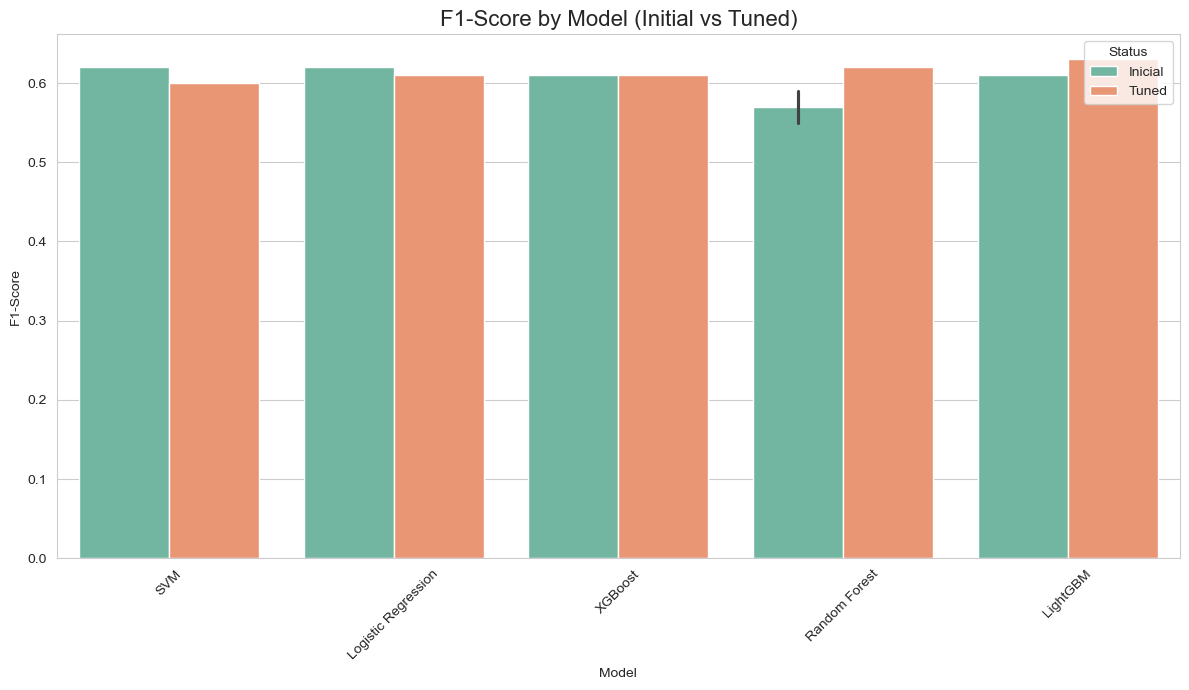

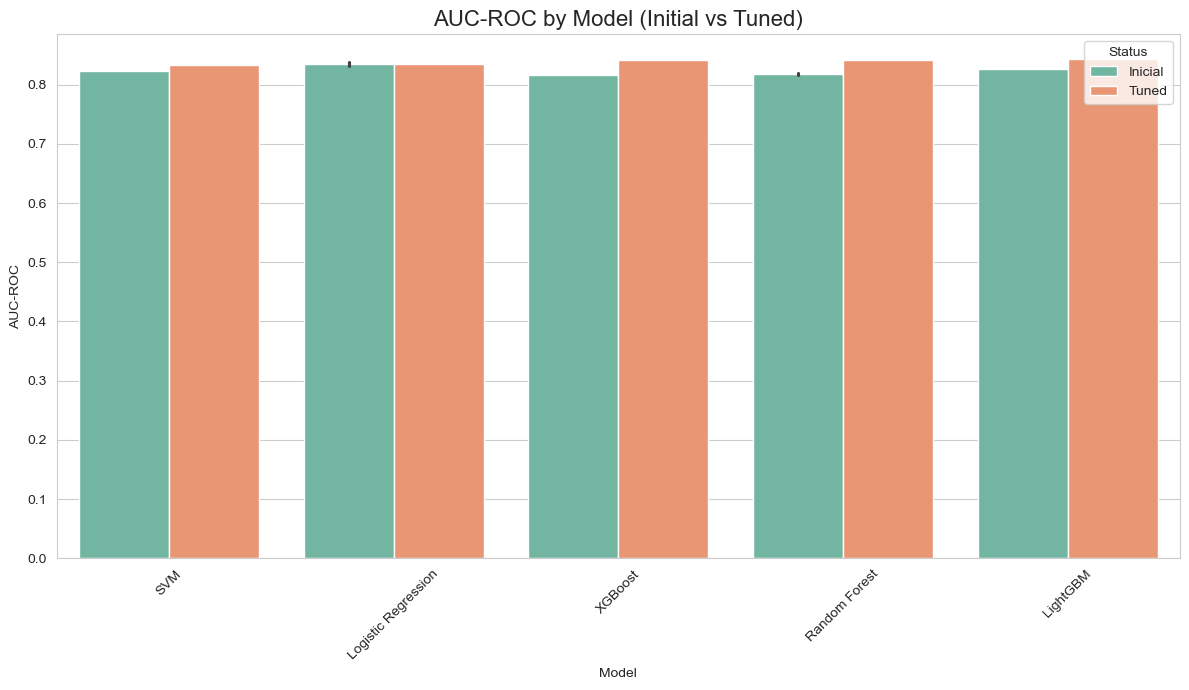

In [55]:
# Visuals: One plot for each metric 
modelos_com_tuned = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'LightGBM']
df_filtered = df_results[df_results['Model'].isin(modelos_com_tuned)]
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
metricas = {
    'Precision (Churn=1)': 'Precision',
    'Recall (Churn=1)': 'Recall',
    'F1-Score (Churn=1)': 'F1-Score',
    'AUC-ROC': 'AUC-ROC'
}
for metrica, titulo in metricas.items():
    ordem = (
        df_filtered[df_filtered["Status"]=="Tuned"]
        .sort_values(by=metrica, ascending=True)["Model"]
        .tolist()
    )
    
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x="Model", y=metrica, hue="Status", 
        data=df_filtered, palette="Set2", order=ordem
    )
    plt.title(f"{titulo} by Model (Initial vs Tuned)", fontsize=16)
    plt.ylabel(titulo)
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

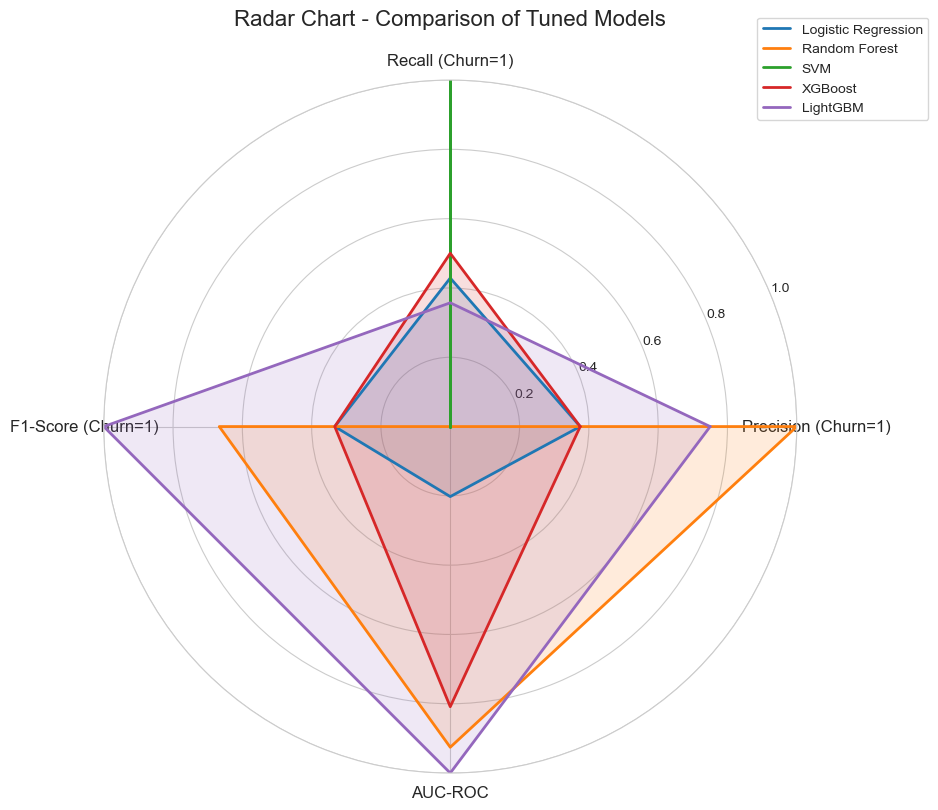

In [56]:
# Radar Chart
df_tuned_only = df_results[df_results['Status'] == "Tuned"].set_index("Model")
metrics = ['Precision (Churn=1)', 'Recall (Churn=1)', 'F1-Score (Churn=1)', 'AUC-ROC']
df_metrics = df_tuned_only[metrics]
df_norm = df_metrics.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
labels = metrics
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
plt.figure(figsize=(9, 9))
ax = plt.subplot(111, polar=True)
for idx, row in df_norm.iterrows():
    values = row.tolist()
    values += values[:1]  # close the plot
    ax.plot(angles, values, label=idx, linewidth=2)
    ax.fill(angles, values, alpha=0.15)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"], fontsize=10)
ax.set_ylim(0, 1)
plt.title("Radar Chart - Comparison of Tuned Models", fontsize=16, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()

Considering the results, the most promising models are:

- Optimized LightGBM: Highest AUC and F1-Score, and an excellent Recall (0.79). It offers the best overall balance.
- Optimized SVM: Highest Recall (0.88), but with the lowest Precision (0.46). It is important to evaluate if the cost of False Positives is justified by the extremely high Recall.

### Treshold Tuning


Now that we have optimized models with excellent metrics, the next step is threshold tuning.

All the models we have used have a default classification threshold of 0.5. This means that if the predicted probability of churn is >= 0.5, the customer is classified as "churn"; otherwise, they are classified as "no churn". However, for our problem, where Recall is the priority and Precision is a secondary concern, the 0.5 threshold may not be optimal.

We need to find a cutoff point that maximizes Recall for the "Churn" class (to avoid missing customers who are going to cancel), while maintaining Precision at an acceptable level (to avoid spending excessive resources on False Positives).

## LightGBM and SVM - Tunned


--- Cutoff Point Analysis for: Optimized LightGBM ---
Area Under the Precision-Recall Curve (AUPRC): 0.6565


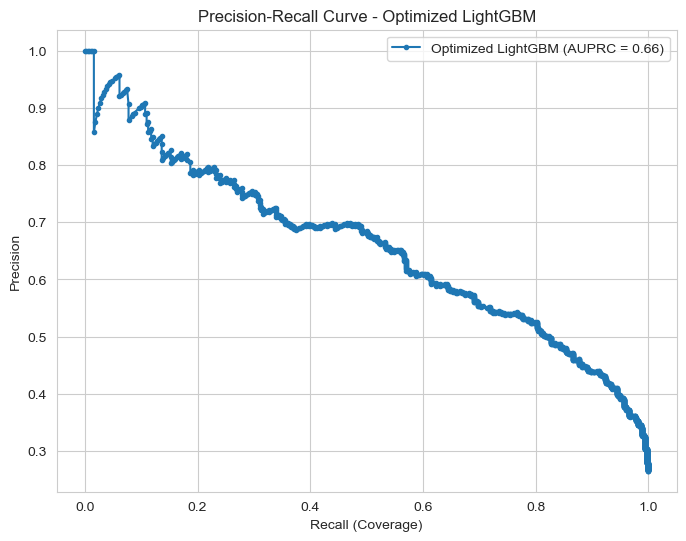


Precision and Recall at different Cutoff Points:
Threshold | Precision  | Recall
----------------------------
0.01      | 0.27       | 1.00  
0.04      | 0.30       | 1.00  
0.07      | 0.34       | 0.99  
0.16      | 0.38       | 0.96  
0.28      | 0.43       | 0.92  
0.42      | 0.49       | 0.83  
0.59      | 0.55       | 0.71  
0.71      | 0.65       | 0.56  
0.81      | 0.72       | 0.32  
0.95      | 1.00       | 0.00  

Evaluation Example with a Custom Threshold (Default 0.5):
Classification Report for Threshold = 0.50:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.52      0.79      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409



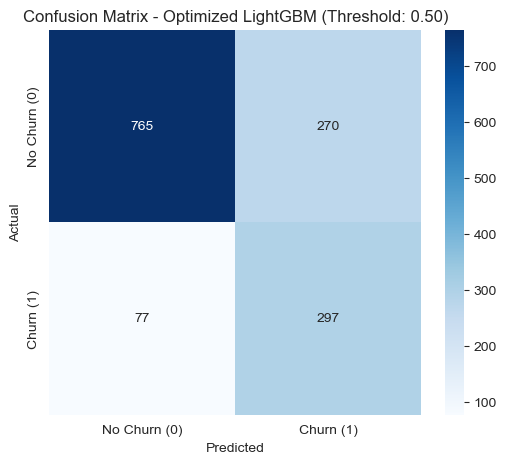


--- Cutoff Point Analysis for: Optimized SVM ---
Area Under the Precision-Recall Curve (AUPRC): 0.6254


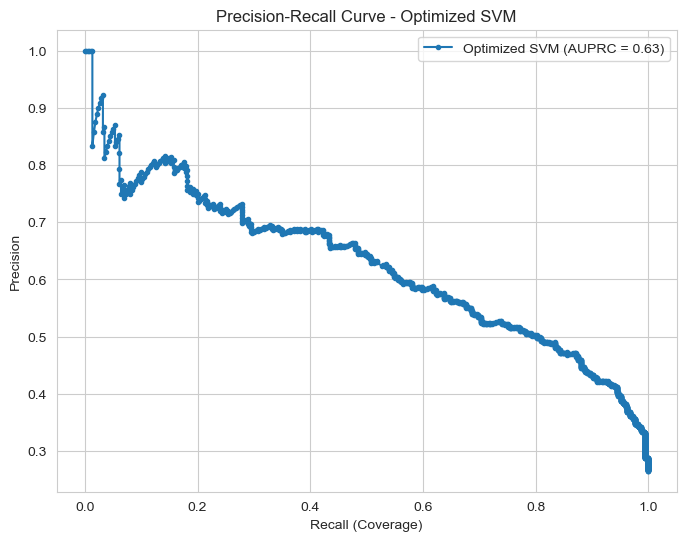


Precision and Recall at different Cutoff Points:
Threshold | Precision  | Recall
----------------------------
0.00      | 0.27       | 1.00  
0.02      | 0.30       | 0.99  
0.04      | 0.34       | 0.99  
0.08      | 0.38       | 0.96  
0.14      | 0.43       | 0.90  
0.22      | 0.49       | 0.82  
0.32      | 0.54       | 0.69  
0.49      | 0.62       | 0.53  
0.68      | 0.70       | 0.29  
0.88      | 1.00       | 0.00  

Evaluation Example with a Custom Threshold (Default 0.5):
Classification Report for Threshold = 0.50:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409



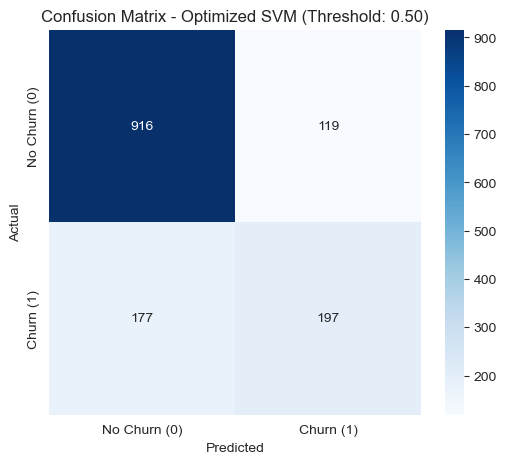

In [57]:
# Function to Plot PR Curve and Evaluate Thresholds ---
def plot_pr_curve_and_evaluate_threshold(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    auprc = auc(recall, precision)
    print(f"\n--- Cutoff Point Analysis for: {model_name} ---")
    print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.4f}")
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUPRC = {auprc:.2f})')
    plt.xlabel('Recall (Coverage)')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("\nPrecision and Recall at different Cutoff Points:")
    selected_threshold_indices = np.linspace(0, len(thresholds) - 1, 10).astype(int)
    print("Threshold | Precision  | Recall")
    print("----------------------------")
    for i in selected_threshold_indices:
        idx = min(i, len(thresholds) - 1)
        print(f"{thresholds[idx]:<9.2f} | {precision[idx]:<8.2f}   | {recall[idx]:<6.2f}")

    print("\nEvaluation Example with a Custom Threshold (Default 0.5):")
    custom_threshold = 0.5
    y_pred_custom_threshold = (y_proba >= custom_threshold).astype(int)
    print(f"Classification Report for Threshold = {custom_threshold:.2f}:")
    print(classification_report(y_test, y_pred_custom_threshold))
    cm_custom = confusion_matrix(y_test, y_pred_custom_threshold)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn (0)', 'Churn (1)'],
                yticklabels=['No Churn (0)', 'Churn (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name} (Threshold: {custom_threshold:.2f})')
    plt.show()
# Optimized LightGBM
plot_pr_curve_and_evaluate_threshold(best_lgbm_model, X_test, y_test, "Optimized LightGBM")
# Optimized SVM
plot_pr_curve_and_evaluate_threshold(best_svm_model, X_test, y_test, "Optimized SVM")

### Model Selection

Considering our primary objective to prioritize Recall (capturing the maximum number of churners), without completely disregarding Precision (to avoid wasting resources):

The Optimized LightGBM with the default cutoff point of 0.50 proves to be the most balanced and effective choice.

It achieves a Recall of 0.79, meaning it correctly identifies 79% of the customers who will actually cancel. This is excellent for proactive retention.

It maintains a Precision of 0.52, which indicates that of the customers the model flags as potential churners, a little over half will actually cancel. This implies a manageable cost of False Positives.

Its F1-Score of 0.63 is the highest among the optimized models, confirming its strong balance.

Its AUPRC (0.6565) and AUC-ROC (0.8428) are the highest, attesting to its overall robustness.

The Optimized SVM is impressive for its potential for an extremely high Recall (reaching 0.88 at lower thresholds), but the drop in Precision would be too steep (below 0.50) to justify its selection for this project. This would only be viable if the cost of a False Positive were absolutely negligible, which is rarely the case in retention strategies.

### Conclusion
Chosen Model: Optimized LightGBM Classifier
Treshold: 0.50 (default)

The Optimized LightGBM, using its default cutoff point of 0.50, offers the best balance between detecting customers who will actually cancel (79% Recall) and minimizing unnecessary interventions (52% Precision). This balance is ideal for a business strategy where the priority is to retain customers, ensuring that the majority of potential churners are identified, while simultaneously optimizing the use of retention resources. Its superior performance in AUPRC and AUC-ROC also attests to its overall discriminatory power.

In [58]:
## esconder código
# salvar o modelo treinado
joblib.dump(best_lgbm_model, "best_lgbm_model.pkl")
print("Modelo salvo como best_lgbm_model.pkl")
# carregar o modelo salvo
loaded_lgbm_model = joblib.load("best_lgbm_model.pkl")
# usar para prever
y_pred_loaded = loaded_lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded))

Modelo salvo como best_lgbm_model.pkl
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.52      0.79      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409



## Feature Importance

Feature Importance Analysis seeks to quantify the contribution of each variable (feature) in our dataset to the model's predictions. In other words, it helps us understand which customer characteristics have the greatest impact on the probability of churn, revealing the "triggers" and "protectors" behind this behavior.

For this analysis, we will employ the SHAP (SHapley Additive exPlanations) methodology. SHAP is an advanced and widely respected technique known for its ability to offer transparent and fair interpretability. Unlike simpler methods, SHAP not only tells us "how important" a feature is, but also:

* The Magnitude of the Impact: How much a feature, on average, pushes the churn prediction up or down.

* The Direction of the Impact: Whether high or low values of a feature tend to increase or decrease the probability of churn.

* Individual Context: How each feature affects the churn prediction for each individual customer, allowing for a detailed understanding.

Why is this analysis vital for the Business?

Understanding the importance and directionality of features is fundamental for:

* Strategic Prioritization: Directing marketing, sales, and customer service resources to the areas that truly make a difference in retention.

* Developing Focused Actions: Creating retention campaigns, adjusting product/service offerings, or improving aspects of customer service based on concrete evidence.

* Identifying Opportunities: Discovering new insights into the profile of customers who churn and those who remain loyal.

By the end of this analysis, we will have a clear view of the main drivers of churn, empowering the business to make more informed and proactive decisions to improve the satisfaction and loyalty of our customers.

In [59]:
def plot_top_importances(df_imp, value_col, top_n=20, title="Feature Importance"):
    dfp = df_imp.sort_values(value_col, ascending=False).head(top_n)
    plt.figure(figsize=(8, 6))
    plt.barh(dfp["feature"][::-1], dfp[value_col][::-1])
    plt.title(title)
    plt.xlabel(value_col)
    plt.tight_layout()
    plt.show()

def group_by_parent_feature(feature_names):
    parents = []
    for f in feature_names:
        parents.append(f.split('_', 1)[0])
    return np.array(parents)

def aggregate_grouped_importances(values, feature_names, agg="sum"):
    parents = group_by_parent_feature(feature_names)
    df = pd.DataFrame({"feature": feature_names, "value": values, "parent": parents})
    if agg == "sum":
        agg_df = (df.assign(value_abs=lambda d: d["value"].abs())
                    .groupby("parent", as_index=False)["value_abs"].sum()
                    .rename(columns={"parent":"feature", "value_abs":"value"}))
    elif agg == "mean":
        agg_df = (df.assign(value_abs=lambda d: d["value"].abs())
                    .groupby("parent", as_index=False)["value_abs"].mean()
                    .rename(columns={"parent":"feature", "value_abs":"value"}))
    else:
        raise ValueError("agg must be 'sum' or 'mean'")
    return agg_df


#### Gain

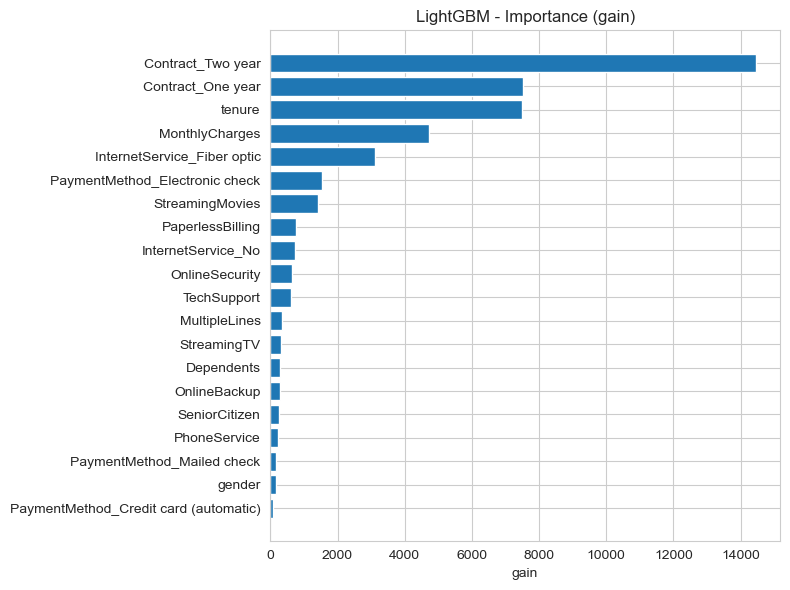

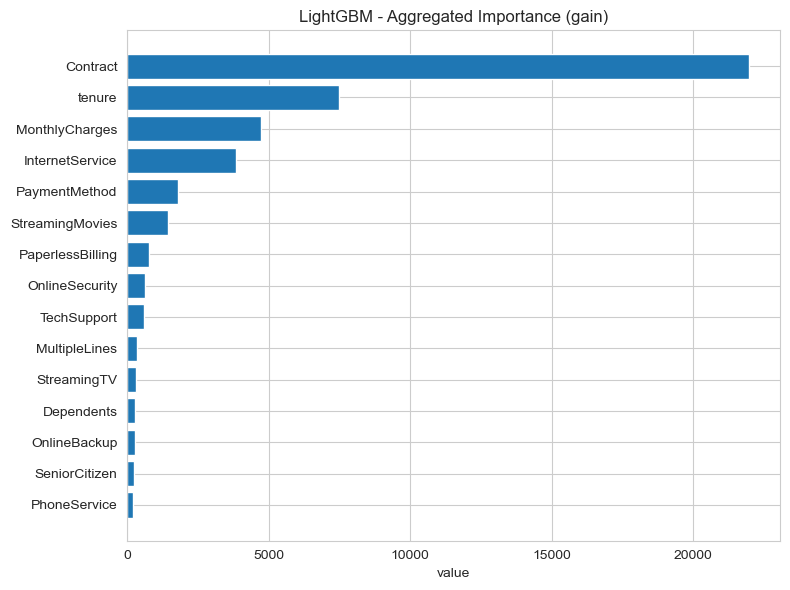

,feature,value
0,Contract,21974.212258
1,Dependents,292.833550
2,DeviceProtection,14.491150
3,InternetService,3850.850205
4,MonthlyCharges,4717.019296
5,MultipleLines,346.108218
6,OnlineBackup,278.130722
7,OnlineSecurity,635.388637
8,PaperlessBilling,769.884130
9,Partner,45.985650


In [60]:
# feature names
feat_names = X_train.columns

# importance by "gain"
lgbm = joblib.load('best_lgbm_model.pkl')
gain_importances = lgbm.booster_.feature_importance(importance_type="gain")
imp_gain_df = pd.DataFrame({"feature": feat_names, "gain": gain_importances})
imp_gain_df = imp_gain_df.sort_values("gain", ascending=False)

# detailed plot
plot_top_importances(imp_gain_df, "gain", top_n=20, title="LightGBM - Importance (gain)")

# GROUPED version by 'parent' variable
imp_gain_grouped = aggregate_grouped_importances(gain_importances, feat_names, agg="sum")
plot_top_importances(imp_gain_grouped, "value", top_n=15, title="LightGBM - Aggregated Importance (gain)")
imp_gain_grouped.head(15)

#### Permutation Importance

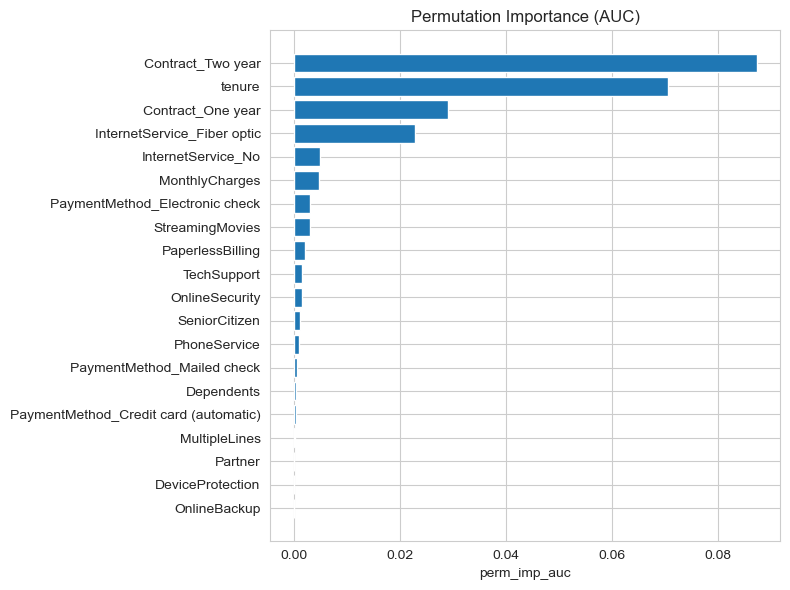

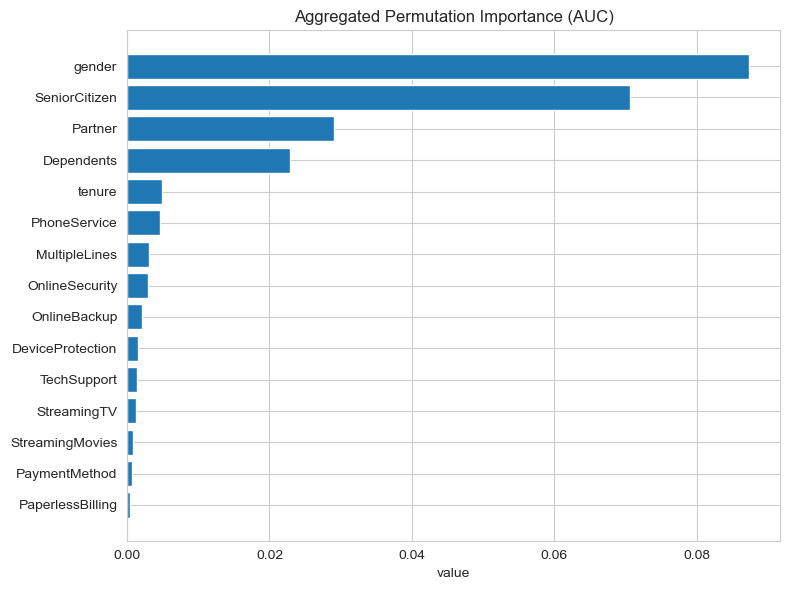

,feature,value
0,Contract,0.000119
1,Dependents,0.022862
2,DeviceProtection,0.001548
3,InternetService,0.000422
4,MonthlyCharges,0.000307
5,MultipleLines,0.003007
6,OnlineBackup,0.002141
7,OnlineSecurity,0.002959
8,PaperlessBilling,0.000470
9,Partner,0.029104


In [61]:
perm = permutation_importance(
    lgbm, X_test, y_test,
    n_repeats=10, random_state=42, scoring="roc_auc"
)
imp_perm_df = pd.DataFrame({
    "feature": feat_names,
    "perm_imp_auc": perm.importances_mean,
    "perm_imp_std": perm.importances_std
}).sort_values("perm_imp_auc", ascending=False)

plot_top_importances(imp_perm_df, "perm_imp_auc", top_n=20, title="Permutation Importance (AUC)")

# GROUPED by 'parent' variable
imp_perm_grouped = aggregate_grouped_importances(imp_perm_df["perm_imp_auc"].values, feat_names, agg="sum")
plot_top_importances(imp_perm_grouped, "value", top_n=15, title="Aggregated Permutation Importance (AUC)")
imp_perm_grouped.head(15)


#### SHAP Analysis

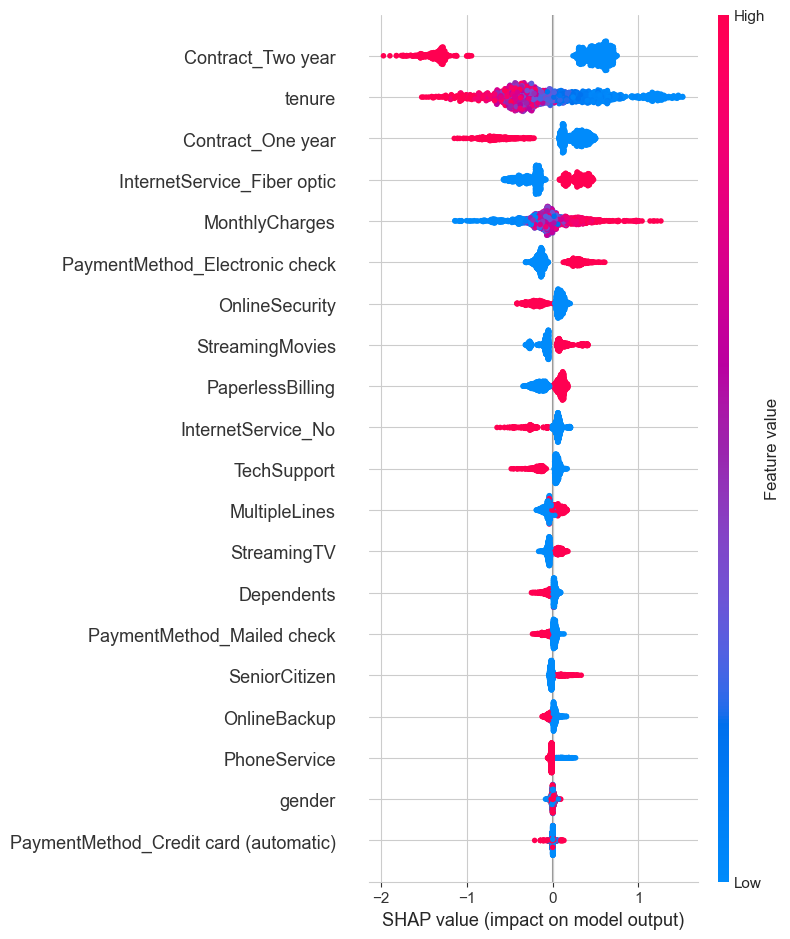

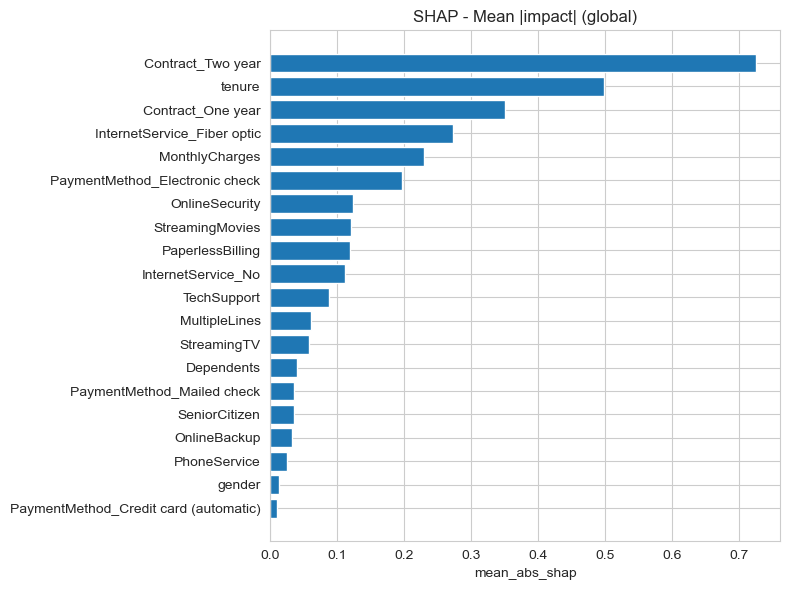

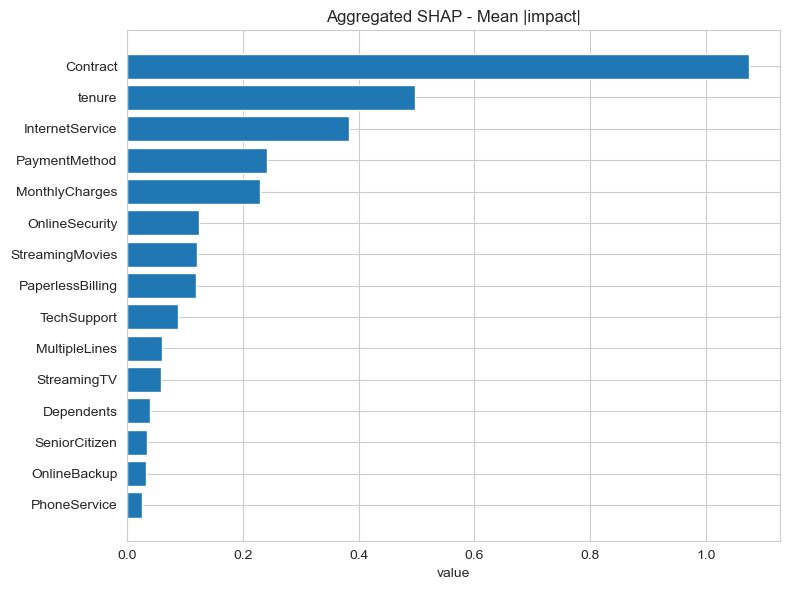

,feature,mean_abs_shap,direction_corr,signal
0,Contract_Two year,0.724372,-0.987947,↓ risk
1,tenure,0.497586,-0.862675,↓ risk
2,Contract_One year,0.350179,-0.942685,↓ risk
3,InternetService_Fiber optic,0.272144,0.923495,↑ risk
4,MonthlyCharges,0.229929,0.774371,↑ risk
5,PaymentMethod_Electronic check,0.196693,0.966441,↑ risk
6,OnlineSecurity,0.123907,-0.937402,↓ risk
7,StreamingMovies,0.121011,0.811060,↑ risk
8,PaperlessBilling,0.119186,0.927893,↑ risk
9,InternetService_No,0.111858,-0.927692,↓ risk


In [62]:
# Sample
X_sample = X_test.copy()
if X_sample.shape[0] > 2000:
    X_sample = X_sample.sample(2000, random_state=42)

# Explainer for LightGBM
lgbm = joblib.load('best_lgbm_model.pkl')
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_sample)

# For binary, shap_values
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

# 5.1) Beeswarm (global)
shap.summary_plot(sv, X_sample, show=True)

# 5.2) Importance by mean |SHAP|
mean_abs = np.abs(sv).mean(axis=0)
imp_shap_df = pd.DataFrame({"feature": X_sample.columns, "mean_abs_shap": mean_abs})\
                 .sort_values("mean_abs_shap", ascending=False)

plot_top_importances(imp_shap_df, "mean_abs_shap", top_n=20, title="SHAP - Mean |impact| (global)")

# 5.3) Directionality
def shap_direction(sv, X):
    dirs = []
    for i, f in enumerate(X.columns):
        xcol = pd.to_numeric(X[f], errors="coerce")
        corr = np.corrcoef(xcol.fillna(xcol.mean()), sv[:, i])[0, 1]
        dirs.append(corr)
    return pd.DataFrame({"feature": X.columns, "direction_corr": dirs})

dir_df = shap_direction(sv, X_sample)

shap_exec_df = (imp_shap_df.merge(dir_df, on="feature")
                            .assign(signal=lambda d: np.where(d["direction_corr"]>=0, "↑ risk", "↓ risk")))

# GROUPED by 'parent' for dummies
shap_group = aggregate_grouped_importances(imp_shap_df["mean_abs_shap"].values, imp_shap_df["feature"].values, agg="sum")
plot_top_importances(shap_group, "value", top_n=15, title="Aggregated SHAP - Mean |impact|")

shap_exec_df.head(20)


#### PDP (Partial Dependence Plots)

<Figure size 600x400 with 0 Axes>

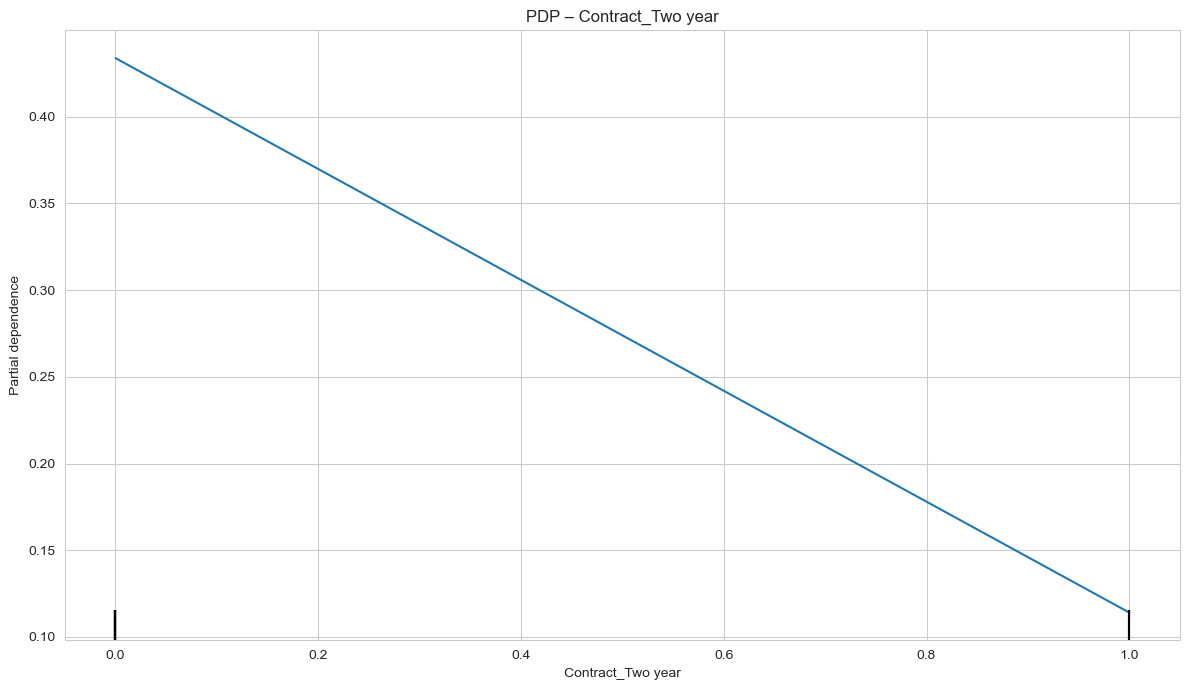

<Figure size 600x400 with 0 Axes>

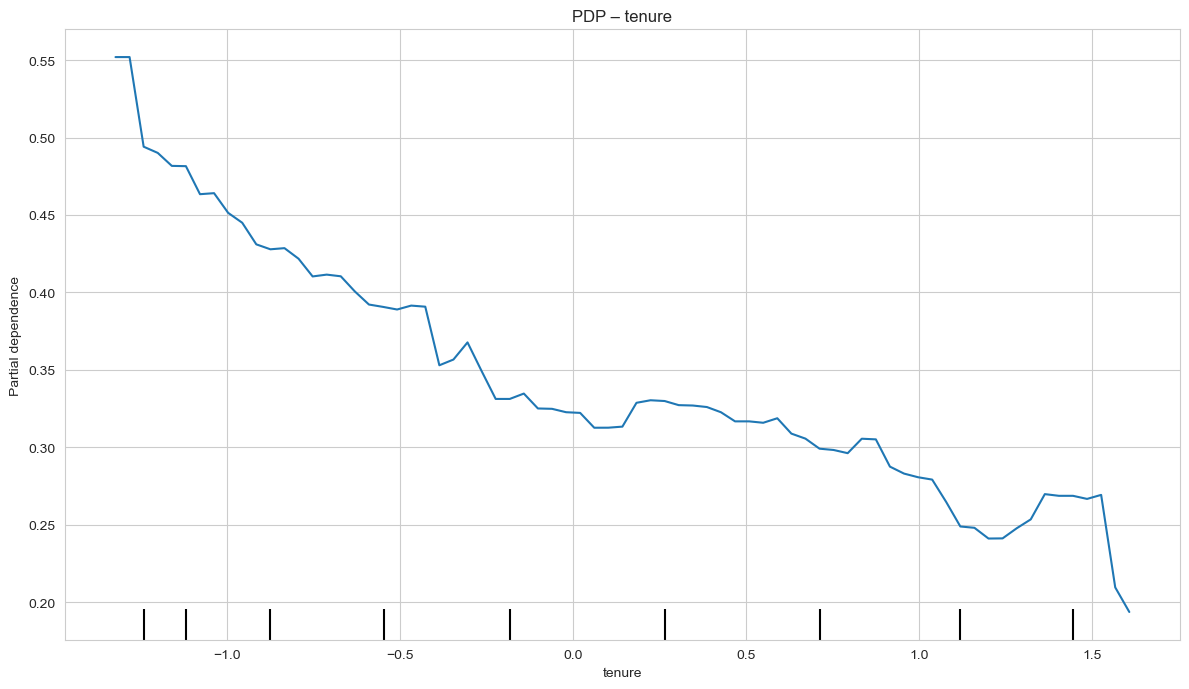

<Figure size 600x400 with 0 Axes>

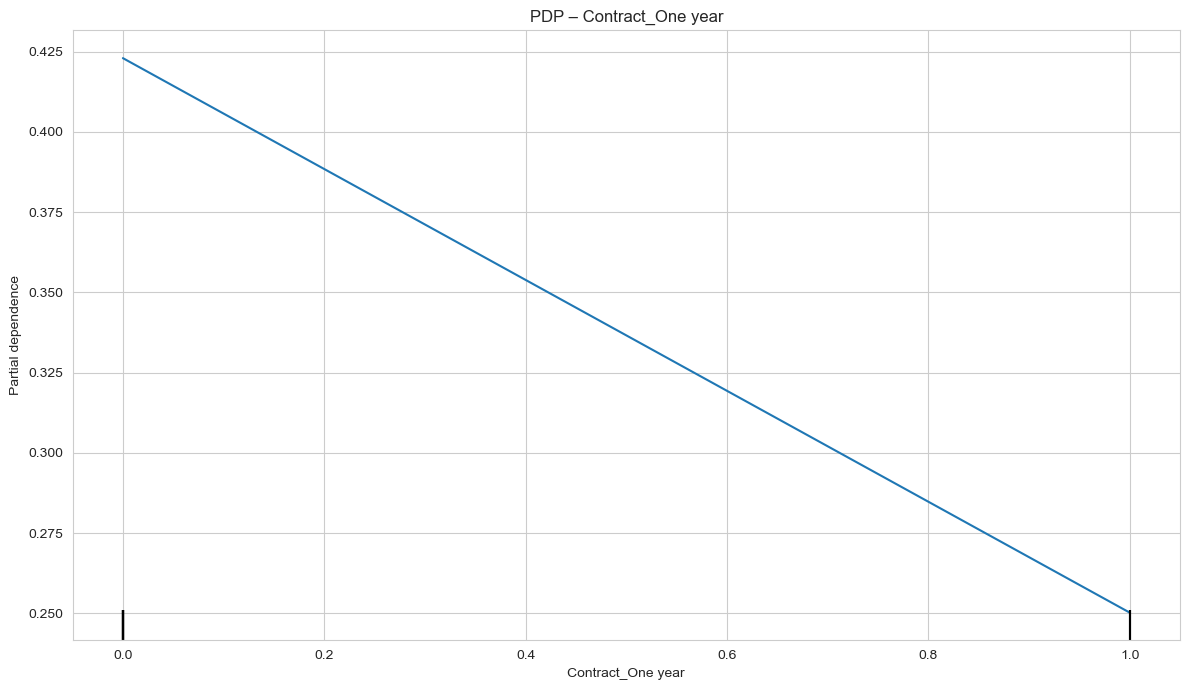

<Figure size 600x400 with 0 Axes>

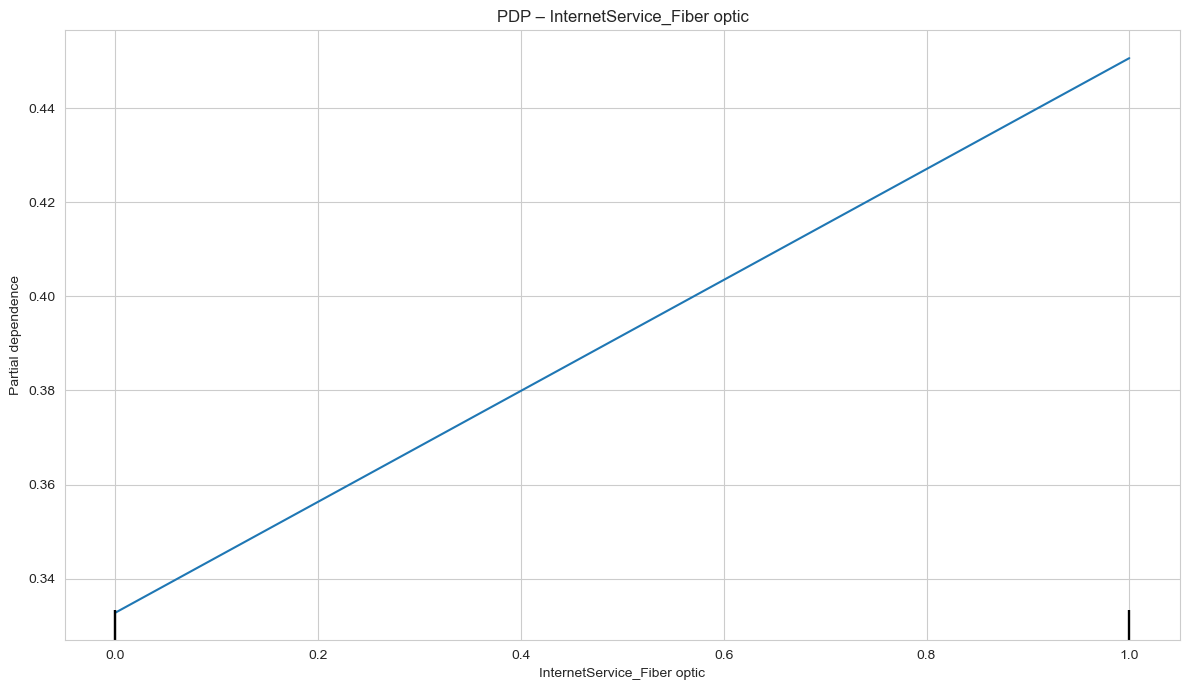

<Figure size 600x400 with 0 Axes>

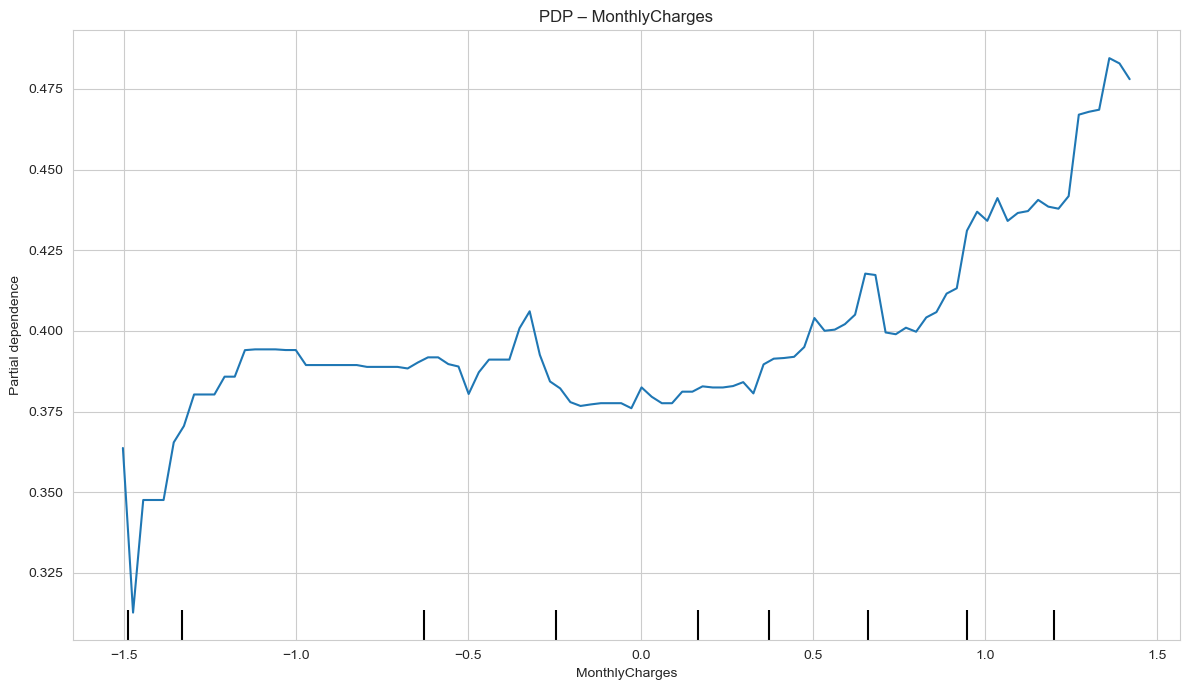

<Figure size 600x400 with 0 Axes>

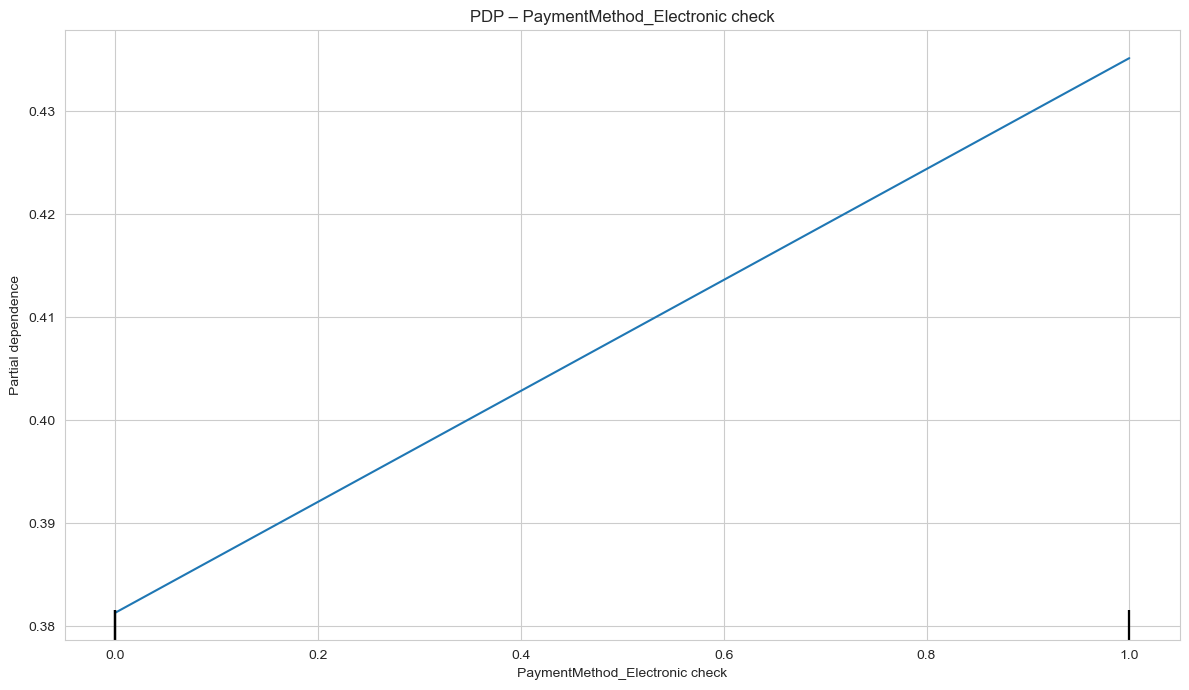

In [63]:
# select top 6 by SHAP global metric
top6 = imp_shap_df["feature"].head(6).tolist()

for f in top6:
    fig = plt.figure(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(lgbm, X_test, [f], kind="average")
    plt.title(f"PDP – {f}")
    plt.tight_layout()
    plt.show()

#### Consolidated Ranking

In [64]:
# normalize and combine
r_gain = imp_gain_df.assign(rank_gain=lambda d: d["gain"].rank(ascending=False))
r_perm = imp_perm_df.assign(rank_perm=lambda d: d["perm_imp_auc"].rank(ascending=False))[["feature","rank_perm"]]
r_shap = imp_shap_df.assign(rank_shap=lambda d: d["mean_abs_shap"].rank(ascending=False))[["feature","rank_shap"]]

rank_df = (r_gain[["feature","rank_gain"]]
           .merge(r_perm, on="feature", how="outer")
           .merge(r_shap, on="feature", how="outer")
           .merge(shap_exec_df[["feature","direction_corr","signal"]], on="feature", how="left"))

rank_df["rank_mean"] = rank_df[["rank_gain","rank_perm","rank_shap"]].mean(axis=1)
rank_df = rank_df.sort_values("rank_mean").reset_index(drop=True)

# Show consolidated top 15
rank_df.head(15)

,feature,rank_gain,rank_perm,rank_shap,direction_corr,signal,rank_mean
0,Contract_Two year,1.0,1.0,1.0,-0.987947,↓ risk,1.000000
1,tenure,3.0,2.0,2.0,-0.862675,↓ risk,2.333333
2,Contract_One year,2.0,3.0,3.0,-0.942685,↓ risk,2.666667
3,InternetService_Fiber optic,5.0,4.0,4.0,0.923495,↑ risk,4.333333
4,MonthlyCharges,4.0,6.0,5.0,0.774371,↑ risk,5.000000
5,PaymentMethod_Electronic check,6.0,7.0,6.0,0.966441,↑ risk,6.333333
6,StreamingMovies,7.0,8.0,8.0,0.811060,↑ risk,7.666667
7,InternetService_No,9.0,5.0,10.0,-0.927692,↓ risk,8.000000
8,PaperlessBilling,8.0,9.0,9.0,0.927893,↑ risk,8.666667
9,OnlineSecurity,10.0,11.0,7.0,-0.937402,↓ risk,9.333333


### Recommendations and Business Actions Based on Insights:

* Contract Type – Two-Year Contracts (Contract_Two year): Customers with two-year contracts show a significantly lower risk of churn. Encourage migration to this type of contract through offers and benefits.

* Contract Type – One-Year Contracts (Contract_One year): Customers with one-year contracts also present lower churn risk compared to month-to-month contracts, but higher than two-year contracts. Reinforce the value of renewal and promote the transition to longer-term contracts.

* Tenure: Customers with short tenure are at higher risk. Implement robust onboarding programs and proactive follow-up during the first months to ensure satisfaction and early engagement.

* Internet Service – Fiber Optic (InternetService_Fiber optic): The fact that fiber optic customers show higher churn risk is a red flag. Service quality, support, or perceived cost-benefit for fiber users should be urgently investigated. Potential issues may include performance problems or inadequate pricing in this segment.

* Monthly Charges (MonthlyCharges): Higher monthly charges increase churn risk. Analyze the price ranges where churn is most prevalent. Consider offering bundled packages or renegotiation for customers with high charges, especially when combined with low tenure.

* Payment Method – Electronic Check (PaymentMethod_Electronic check): Customers using electronic checks are at high risk. This may indicate a segment with lower loyalty, financial difficulties, or dissatisfaction. Consider incentives to switch to other payment methods or establish closer monitoring for these customers.

* Online Security (OnlineSecurity): Not having online security services increases churn risk. Promote the importance and benefits of online security offerings.

* Streaming Services (StreamingMovies, StreamingTV): Having streaming services may increase churn risk. This is counterintuitive and may suggest that these services are not adding enough value to retain customers, or that customers seeking such services tend to have a profile more prone to exploring alternatives.